In [1]:
from dotenv import load_dotenv
load_dotenv('/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/.env')
%load_ext autoreload
%autoreload 2

MODEL_TO_AESTETICS = {
    'panopticon': ('blue', 'o', 'Panopticon'),
    'dofa': ('orange', 's', 'DOFA'),
    'senpamae': ('brown', 'x', 'SenPa-MAE'),
    'softcon_13b': ('green', '^', 'SoftCon'),
    'croma_12b': ('purple', 'P', 'CROMA'),
    'dinov2': ('red', 'D', 'DINOv2'),
    # 'senpamae_old': ('brown', 'P'),
}

def get_aestetics(model):

    for key, value in MODEL_TO_AESTETICS.items():
        if key in model:
            return value
    raise ValueError(f"Model {model} not found in aesthetics mapping.")

### Build SRFs

In [26]:
""" resisc45 """

import yaml
from geobreeze.models.senpamae import create_srf_from_mu_std
import torch
import numpy as np

# p = '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/intuition.yaml'
# cfg = yaml.safe_load(open(p, 'r'))
# mus = [b['gaussian']['mu'] for b in cfg['bands'].values()]
# std = [b['gaussian']['sigma'] for b in cfg['bands'].values()]

mus = [665, 560, 490]
std = [12,12,12]

mus = torch.tensor(mus)
std = torch.tensor(std)
vals = create_srf_from_mu_std(mus, std)
print(vals.shape)
np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/resisc45.npy', vals.numpy(), )

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2301, 3])


/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
""" intuition """
import yaml
from geobreeze.models.senpamae import create_srf_from_mu_std
import torch
import numpy as np

p = '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/intuition.yaml'
cfg = yaml.safe_load(open(p, 'r'))
mus = [b['gaussian']['mu'] for b in cfg['bands'].values()]
std = [b['gaussian']['sigma'] for b in cfg['bands'].values()]

mus = torch.tensor(mus)
std = torch.tensor(std)
vals = create_srf_from_mu_std(mus, std)
print(vals.shape)
np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/intuition.npy', vals.numpy(), )

torch.Size([2301, 150])


In [ ]:
np.load('/home/hk-project-pai00028/tum_mhj8661/code/srfs/landsat8_srf.npy').shape

(2301, 9)

In [ ]:
""" landsat """
import pandas as pd
import os
import numpy as np

root = '/home/hk-project-pai00028/tum_mhj8661/code/landsat8_srf/'

# load
out = {}
for f in os.listdir(root):
    df = pd.read_csv(os.path.join(root, f), delimiter='\t')
    out[f.split('.')[0]] = df

# process
for k, v in out.items():
    new_out = np.zeros(2400)
    new_out[v['Wavelength']] = v['BARSR[watts]']
    out[k] = new_out

out = np.stack(list(out.values()), axis=0).T
out = out[:2301, :]
print(out.shape)

# save
np.save('/home/hk-project-pai00028/tum_mhj8661/code/srfs/landsat8_srf.npy', out)

(2301, 9)


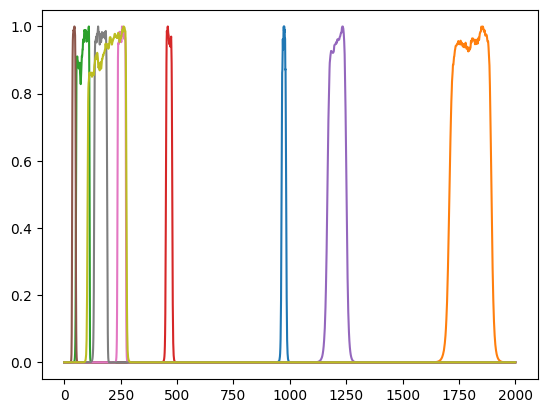

In [38]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(out.shape[0]):
    plt.plot(out[i,400:2400], label=f'Band {i+1}')


### Debug SenpaMAE

In [48]:
from geobreeze.datasets.geobench import GeoBenchDataset
from geobreeze.datasets.base import collate_fn

ds = GeoBenchDataset(
    'm-eurosat',
    split='train',
)


batch = collate_fn([ds[i] for i in range(4)])
batch[0]['gsd'].shape


/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([4, 13])

In [49]:
batch[0]['chn_ids'].shape

torch.Size([4, 13])

In [37]:
import torch
batch = torch.utils.data.default_collate([ds[i] for i in range(4)])

batch[0]['band_ids']

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])

In [35]:
ds[0][0]['band_ids']

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [23]:
import torch

x = torch.ones((2,3,4))
x[0].shape

torch.Size([3, 4])

In [2]:
import numpy as np
import os

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
arr = np.load(os.path.join(root,'rfs_sentinel2_a_13b.npy'))
arr.shape

(2301, 13)

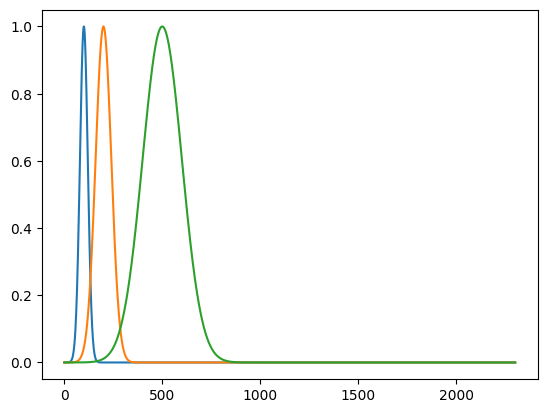

In [28]:
from torch import Tensor
import torch

def _create_srf_from_mu_std(mus: Tensor, sigmas: Tensor):
    assert mus.shape[0] == sigmas.shape[0]
    x_min, x_max = 0, 2301
    x = torch.linspace(x_min, x_max, 2301).unsqueeze(0).to(mus.device)
    vals = torch.exp(-0.5 * ((x - mus.unsqueeze(1)) / sigmas.unsqueeze(1)) ** 2)
    vals = vals / vals.max(dim=1, keepdim=True)[0]
    return vals

vals = _create_srf_from_mu_std(
    torch.tensor([100, 200, 500]),
    torch.tensor([20, 40, 100])
)

vals.shape

import matplotlib.pyplot as plt

plt.figure()
for i in range(vals.shape[0]):
    plt.plot(vals[i,:], label=f'Band {i+1}')


In [27]:
import numpy as np

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
p = 'rfs_landsat.npy'
arr = np.load(os.path.join(root,p))
print(arr.shape)
indices = np.argmax(arr, axis=0)
for i in indices:
    print(i)

(2301, 7)
145
209
250
356
559
1333
1955


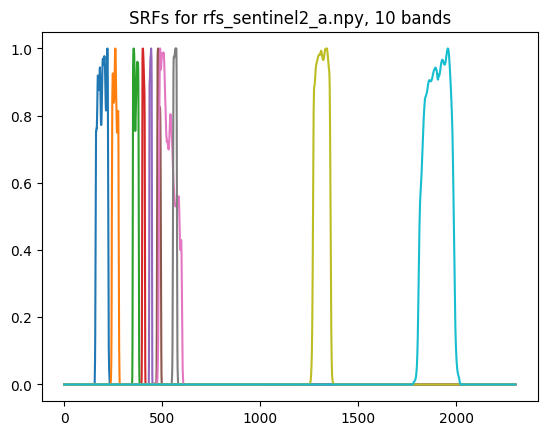

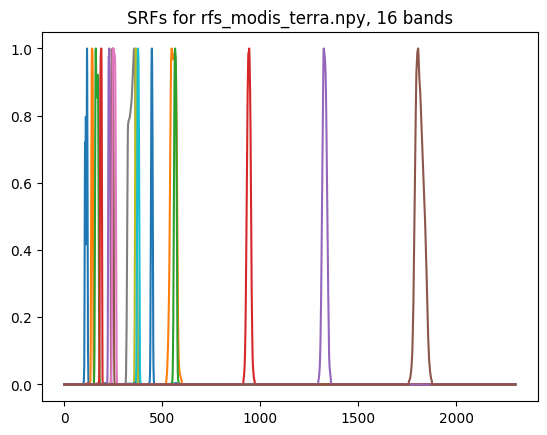

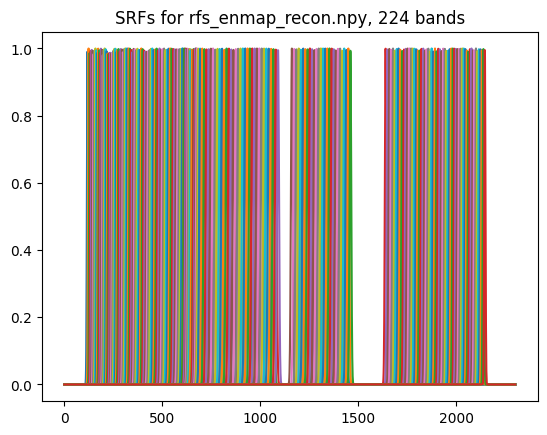

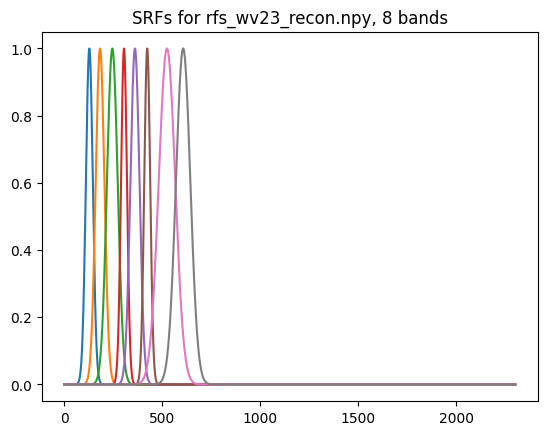

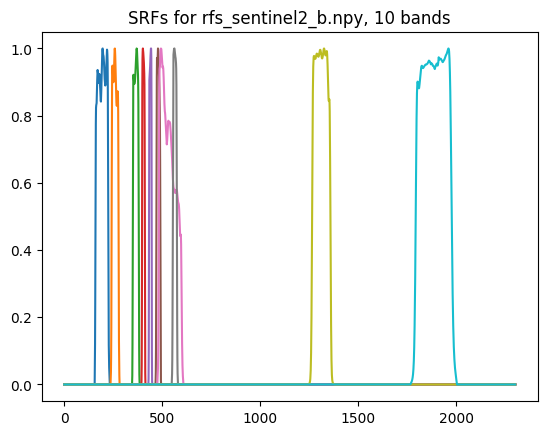

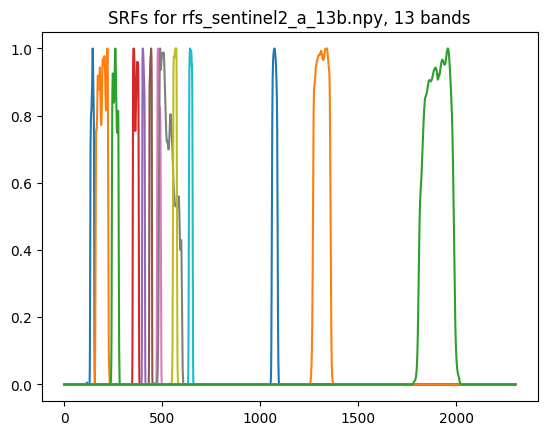

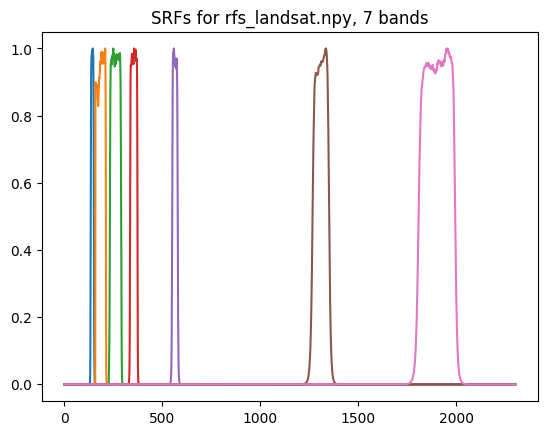

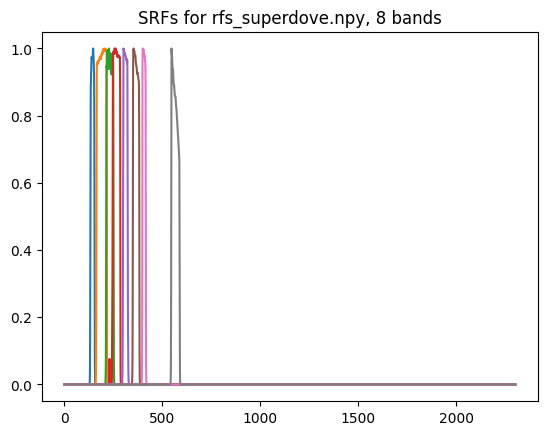

In [6]:
import matplotlib.pyplot as plt

for f in os.listdir(root):
    if not f.endswith('.npy'):
        continue

    arr = np.load(os.path.join(root, f))
    plt.figure()
    for i in range(arr.shape[1]):
        plt.plot(arr[:, i], label=f'Band {i+1}')
    plt.title(f'SRFs for {f}, {arr.shape[1]} bands')

### Cross Sensor

In [5]:
from geobreeze.collect_results import collect_csv

collect_csv('/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/submission')

,metric,val,best_classifier,relpath
0,MulLabAvergPrec_macro,0.583226,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
1,MulLabAvergPrec_micro,0.731388,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
2,MulLabF1ScoreMacro_macro,0.525878,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
3,MulLabF1ScoreMacro_micro,0.660664,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-SD/base/dinov2/bsz=400_e=50
4,MAE,0.394118,blocks_1_pooling_cls_lr_0_00586_1dbn_True,hyperview-SD/base/dinov2/bsz=300_e=50
5,MSE,0.339920,blocks_1_pooling_cls_lr_0_00586_1dbn_True,hyperview-SD/base/dinov2/bsz=300_e=50
6,RMSE,0.583027,blocks_1_pooling_cls_lr_0_00586_1dbn_True,hyperview-SD/base/dinov2/bsz=300_e=50
7,MulLabAvergPrec_macro,0.585021,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-MD/base/dinov2/bsz=400_e=50
8,MulLabAvergPrec_micro,0.732285,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-MD/base/dinov2/bsz=400_e=50
9,MulLabF1ScoreMacro_macro,0.523236,blocks_4_pooling_avgpool_lr_0_15625_1dbn_True,corine-MD/base/dinov2/bsz=400_e=50


In [22]:
import os
import pandas as pd
from geobreeze.collect_results import collect_csv

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor'
collect_csv(p)
df = pd.read_csv(os.path.join(p, 'results.csv')).drop(columns=['Unnamed: 0'])

df['model'] = df['relpath'].apply(lambda x: x.split('/')[2])
df['relpath'] = df['relpath'].apply(lambda x: x.replace('_rgb/','/'))
df['ds'] = df['relpath'].apply(lambda x: x.split('/')[0].split('_')[1])
df['train_ds'] = df['relpath'].apply(lambda x: x.split('/')[0].split('_')[-2])

df['test_ds'] = ''
for i in range(len(df)):
    test_ds_idx = int(df.iloc[i]['metric'].split('_')[-1])
    test_datasets = df.iloc[i]['relpath'].split('/')[0].split('_')[-2:]
    df['test_ds'][i] = test_datasets[test_ds_idx]

df['ds_str'] = df['train_ds'] + '->' + df['test_ds']
df['metric'] = df['metric'].apply(lambda x: x.split('_')[0])
df = df[df['metric'].isin(['acc','MSE'])]
df = df.groupby(['model','ds','ds_str','metric','train_ds','test_ds']).agg({'val': 'max'}).reset_index()
# display(df)

# add normalization
norms = {}
for i in range(len(df)):
    if df.iloc[i]['train_ds'] == df.iloc[i]['test_ds']:
        key = (df.iloc[i]['model'], df.iloc[i]['ds'], df.iloc[i]['train_ds'])
        val = df.iloc[i]['val']
        norms[key] = val

df['base_val'] = pd.Series([norms[model,ds,sens] 
        for model,ds,sens in zip(df['model'],df['ds'], df['train_ds'])])  
df['prc'] = df['val'] / df['base_val']

# everything absolute
# for metric in df['metric'].unique():
#     dfprint = df[df['metric'] == metric]
#     print(metric)
#     dfprint = dfprint.pivot(index='model', columns='ds_str', values='val')
#     display(dfprint)


# only diff
# for metric in df['metric'].unique():
#     print(metric)
#     dfprint = df[df['metric'] == metric]
#     dfprint = dfprint.pivot(index='model', columns='ds_str', values='val')
#     dfprint['MD->SD (prc)'] = dfprint['MD->SD'] / dfprint['MD->MD']
#     dfprint['SD->MD (prc)'] = dfprint['SD->MD'] / dfprint['SD->SD']
#     display(dfprint)


df['ds_str'] = df['ds'] + ':' + df['ds_str']
df = df[df['train_ds'] != df['test_ds']]

dfcls = df[df['metric'] == 'acc']
dfcls['prc'] = round((dfcls['prc']-1.0)*100 , 1)
dfcls = dfcls.pivot(index='model', columns='ds_str', values='prc')
display(dfcls)

dfreg = df[df['metric'] == 'MSE']
dfreg['prc'] = round((dfreg['prc']-1.0)*100 , 1)
dfreg = dfreg.pivot(index='model', columns='ds_str', values='prc')
display(dfreg)

/scratch/ipykernel_2811788/3032963934.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_ds'][i] = test_datasets[test_ds_idx]
/scratch/ipykernel_2811788/3032963934.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcls['prc'] = round((dfcls['prc']-1.0)*100 , 1)


ds_str,eurosat:s1->s2,eurosat:s2->s1,so2sat:s1->s2,so2sat:s2->s1
model,,,,
dinov2,NaN,NaN,-73.9,-80.7
dofa,-77.5,-73.3,-63.2,-82.8
panopticon,-50.2,-48.2,-73.8,-86.2


/scratch/ipykernel_2811788/3032963934.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfreg['prc'] = round((dfreg['prc']-1.0)*100 , 1)


ds_str,hypv:MD->SD,hypv:SD->MD
model,,
dinov2,-0.4,0.6
dofa,-2.7,8.8
panopticon,1.0,0.2


### Debug Hyperview

In [7]:
for b in data['bands']:
    print(b)

{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B001', 'gaussian': {'mu': 418.416, 'sigma': 2.972}, 'id': 'enmap/B001'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B002', 'gaussian': {'mu': 424.043, 'sigma': 2.831}, 'id': 'enmap/B002'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B003', 'gaussian': {'mu': 429.457, 'sigma': 2.728}, 'id': 'enmap/B003'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B004', 'gaussian': {'mu': 434.686, 'sigma': 2.654}, 'id': 'enmap/B004'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_recon.npy', 'name': 'B005', 'gaussian': {'mu': 439.758, 'sigma': 2.605}, 'id': 'enmap/B005'}
{'instrument': 'EnMAP', 'processing_level': 'L2A', 'GSD': 30, 'srf_filename': 'rfs_enmap_r

In [12]:
""" get indices"""
import yaml
import torch
from geobreeze.datasets.utils.utils import load_ds_cfg

sats = {
    'SD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/superdove.yaml',
    'MD': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/modis_terra.yaml',
    'hyperview': '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/datasets/metadata/sensors/intuition.yaml',
    'corine': load_ds_cfg('corine'),
    'SD_rgb': torch.tensor([665.8,565.8,491.0]),
    'MD_rgb': torch.tensor([665.7,554.0,487.1])
}

for k,v in sats.items():
    if isinstance(v, str):
        with open(v, 'r') as f:
            data = yaml.safe_load(f)
        sats[k] = torch.tensor([b['gaussian']['mu'] for b in data['bands'].values()])
    elif isinstance(v, dict):
        data = v
        sats[k] = torch.tensor([b['gaussian']['mu'] for b in data['bands']])
    elif isinstance(v, torch.Tensor):
        pass
    else:
        raise ValueError(f"Unsupported type for {k}: {type(v)}")
    

def find(src, tgt):
    if not isinstance(src, torch.Tensor):
        src = torch.tensor(src)
    if not isinstance(tgt, torch.Tensor):
        tgt = torch.tensor(tgt)
    src = src[:, None]
    tgt = tgt[None, :]
    diff = torch.abs(src - tgt)
    min_diff, min_idx = diff.min(dim=0)
    return min_idx, min_diff

# find(sats['hyperview'], sats['MD'])

# find(sats['hyperview'], [665.69,554,487])

find(sats['corine'], sats['SD'])
find(sats['corine'], sats['MD'])
find(sats['corine'], sats['SD_rgb'])
find(sats['corine'], sats['MD_rgb'])

(tensor([47, 28, 14]), tensor([0.9370, 1.8730, 0.0130]))

In [10]:
sats['SD']

tensor([443.7040, 490.9730, 532.7190, 565.8110, 611.5870, 665.7510, 706.9180,
        864.8310])

In [19]:
from geobreeze.datasets.utils.utils import load_ds_cfg

dsconfig = load_ds_cfg('hyperview')

MD = [1,8,21,27,29,57,64,67,89,124,127]
SD = [9,22,32,47,64,77,126]

SD_rgb = [63, 32,  9]

dsconfig = load_ds_cfg('hyperview')
for i in SD_rgb:
    print(dsconfig['bands'][i]['gaussian']['mu'])



663.46
564.37
490.85


In [ ]:
from torchgeo.datasets import 

In [19]:
from geobreeze.datasets import Hyperview
import os

for split in ['train','val','test']:

    ds = Hyperview(
        root = os.path.expandvars('$DATASETS_DIR/hyperview'),
        split = split,
        do_mask = False,
    )

    print(f"Split: {split}")
    print(f"Number of samples: {len(ds)}")

[HyperviewBenchmark] Building dataset for split: train
Split: train
Number of samples: 1298
[HyperviewBenchmark] Building dataset for split: val
Split: val
Number of samples: 174
[HyperviewBenchmark] Building dataset for split: test
Split: test
Number of samples: 260


In [20]:
OmegaConf.load(p).data.test

[{'_target_': 'Hyperview', 'split': 'test', 'root': '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets//hyperview', 'transform': [{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}], 'band_ids': [9, 22, 32, 47, 64, 77, 126]}, {'_target_': 'Hyperview', 'split': 'test', 'root': '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets//hyperview', 'transform': [{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}], 'band_ids': [1, 8, 21, 27, 29, 57, 64, 67, 8, 124, 127]}]

In [11]:
ds

In [ ]:
from geobreeze.factory import 

In [21]:
for xdict,_ in ds:
    print(xdict['imgs'].shape)

pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 43, 42])
post transform torch.Size([150, 43, 42])
torch.Size([150, 43, 42])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 125, 124])
post transform torch.Size([150, 125, 124])
torch.Size([150, 125, 124])
pre transform torch.Size([150, 42, 42])
post transform torch.Size([150, 42, 42])
torch.Size([150, 42, 42])
pre transform torch.Size([150, 104, 120])
post transform torch.Size([150, 104, 120])
torch.Size([150, 104, 120])
pre transform torch.Size([150, 40, 44])
post transform torch.Size([150, 40, 44])
torch.Size([150, 40, 44])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size([150, 11, 11])
post transform torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
pre transform torch.Size(

KeyboardInterrupt: 

In [3]:
from omegaconf import OmegaConf
from geobreeze.factory import make_transform_list, make_dataset
from torch.utils.data import DataLoader
import kornia.augmentation as K
import torch

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor/x_hypv_SD_MD/base/panopticon/bsz=200_e=1/config.yaml'
cfg = OmegaConf.load(p)

trf_list = make_transform_list(cfg.data.train.transform)
trf = K.AugmentationSequential(*trf_list, data_keys=['image'])

img = torch.randn(1, 3, 553, 12)
trf(img).shape

cfg: _target_: <class 'str'>, kornia.augmentation.RandomHorizontalFlip
cfg: p: <class 'float'>, 0.5
cfg: keepdim: <class 'bool'>, True
cfg: _target_: <class 'str'>, kornia.augmentation.RandomVerticalFlip
cfg: p: <class 'float'>, 0.5
cfg: keepdim: <class 'bool'>, True
cfg: _target_: <class 'str'>, kornia.augmentation.RandomResizedCrop
cfg: size: <class 'list'>, [224, 224]
cfg: scale: <class 'list'>, [0.8, 1.0]


TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [10]:
from omegaconf import OmegaConf
from geobreeze.factory import make_transform_list, make_dataset
from torch.utils.data import DataLoader
import kornia.augmentation as K
import torch

cfg = OmegaConf.create([{
    '_target_': 'RandomResizedCrop',
    'size': (224, 224),
    # 'scale': (0.08, 1.0),
}])

trf_list = make_transform_list(cfg)
trf = K.AugmentationSequential(*trf_list, data_keys=['image'])

img = torch.randn(1, 3, 553, 12)
trf(img).shape

torch.Size([1, 3, 224, 224])

In [8]:
import hydra
import kornia.augmentation as K

cfg = OmegaConf.create([{
    '_target_': 'kornia.augmentation.RandomResizedCrop',
    'size': (224, 224),
    # 'scale': (0.08, 1.0),
}])

cfg = OmegaConf.to_container(cfg, resolve=True)
cfg = cfg[0]

cfg.pop('_target_')
trf = K.RandomResizedCrop(**cfg)

img = torch.randn(1, 3, 553, 12)
trf(img).shape

torch.Size([1, 3, 224, 224])

In [42]:
img = torch.randn(1, 3, 553, 12)

trf(img).shape

TypeError: upsample_bilinear2d() received an invalid combination of arguments - got (Tensor, list, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !list of [ListConfig, ListConfig]!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


In [39]:
import torch
import kornia.augmentation as K

trf = K.AugmentationSequential(
    # K.CenterCrop(size=224),
    # K.Resize(size=(224, 224), align_corners=False),
    K.RandomResizedCrop(size=[224,224], scale=[0.08,1.0])
)


img = torch.randn(1, 3, 553, 12)

trf(img).shape

torch.Size([1, 3, 224, 224])

In [16]:
from omegaconf import OmegaConf
from geobreeze.factory import make_dataset
from torch.utils.data import DataLoader

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/xsensor/x_hypv_SD_MD/base/panopticon/bsz=200_e=1/config.yaml'
ds = make_dataset(OmegaConf.load(p).data.train)



dl = DataLoader(
    ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

for i, batch in enumerate(dl):
    print(i)
    print(batch['imgs'].shape)
    break

INFO:eval:Subsampled 7/150 bands with ids [9, 22, 32, 47, 64, 77, 126]. Band names are:
  000: B010
  001: B023
  002: B033
  003: B048
  004: B065
  005: B078
  006: B127


{'_target_': 'kornia.augmentation.RandomHorizontalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'kornia.augmentation.RandomVerticalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'kornia.augmentation.Resize', 'size': 224, 'keepdim': True}
[HyperviewBenchmark] Building dataset for split: train
Got subset=100, subsampled dataset to #samples 100 


RuntimeError: stack expects each tensor to be equal size, but got [7, 229, 224] at entry 0 and [7, 224, 224] at entry 1

In [16]:
ds[idx][0]['imgs']

tensor([[[-8.8704e-01, -1.1546e+00, -1.5263e+00,  ...,  4.3612e-01,
           4.2868e-01,  2.8001e-01],
         [-1.0580e+00, -4.4847e-01, -1.5263e+00,  ..., -4.7061e-02,
           5.7008e-02,  2.7258e-01],
         [-9.1678e-01, -3.2210e-01, -1.0134e+00,  ..., -1.3626e-01,
          -1.0653e-01, -1.2140e-01],
         ...,
         [-2.4776e-01, -2.1803e-01, -1.5113e-01,  ...,  4.1382e-01,
           4.9558e-01,  4.5098e-01],
         [-2.5520e-01, -1.9573e-01, -4.7061e-02,  ...,  4.8815e-01,
           6.6655e-01,  7.1115e-01],
         [-2.4033e-01, -2.1060e-01, -2.8493e-01,  ...,  3.7665e-01,
           4.5098e-01,  4.7328e-01]],

        [[-8.2398e-01, -1.1288e+00, -1.4931e+00,  ...,  4.6228e-01,
           3.8793e-01,  3.5075e-01],
         [-1.0173e+00, -4.4479e-01, -1.5006e+00,  ..., -8.7912e-02,
           1.3078e-03,  2.0205e-01],
         [-8.9833e-01, -3.1840e-01, -9.6524e-01,  ..., -1.1022e-01,
          -1.1765e-01, -1.3252e-01],
         ...,
         [-2.7379e-01, -2

In [13]:
for idx in range(100):
    print(ds[idx][0]['imgs'].shape)

torch.Size([150, 11, 11])
torch.Size([150, 43, 42])
torch.Size([150, 11, 11])
torch.Size([150, 125, 124])
torch.Size([150, 42, 42])
torch.Size([150, 104, 120])
torch.Size([150, 40, 44])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 11, 11])
torch.Size([150, 125, 136])
torch.Size([150, 11, 11])
torch.Size([150, 108, 92])
torch.Size([150, 11, 11])
torch.Size([150, 46, 47])
torch.Size([150, 11, 11])
torch.Size([150, 124, 123])
torch.Size([150, 11, 11])
torch.Size([150, 126, 125])
torch.Size([150, 43, 42])
torch.Size([150, 117, 119])
torch.Size([150, 25, 71])
torch.Size([150, 11, 11])
torch.Size([150, 30, 42])
torch.Size([150, 184, 110])
torch.Size([150, 148, 125])
torch.Size([150, 35, 38])
torch.Size([150, 11, 11])
torch.Size([150, 46, 48])
torch.Size([150, 43, 42])
torch.Size([150, 70, 129])
torch.Size([150, 42, 42])
torch.Size([150, 11, 11])
torch.Size([150, 111, 110])
torch.Size([150, 46, 48])
torch.Size([150, 1

In [9]:
ds.dataset.df['file_paths'].apply(lambda x: x.split('/')[-3:])

0       [hyperview, train_data, 364.npz]
1       [hyperview, train_data, 945.npz]
2       [hyperview, train_data, 596.npz]
3      [hyperview, train_data, 1353.npz]
4       [hyperview, train_data, 955.npz]
                     ...                
255    [hyperview, train_data, 1258.npz]
256     [hyperview, train_data, 284.npz]
257    [hyperview, train_data, 1360.npz]
258    [hyperview, train_data, 1135.npz]
259    [hyperview, train_data, 1322.npz]
Name: file_paths, Length: 260, dtype: object

### Create large eval table 

In [4]:
import pandas as pd

def get_alldf():
    p = '/home/hk-project-pai00028/tum_mhj8661/code/table2.csv'
    table2_df = pd.read_csv(p)
    table2_df = table2_df[['benv2-s2','benv2-s1','RESISC45']]

    # p = '/home/hk-project-pai00028/tum_mhj8661/code/table_generalization.csv'
    p = '/home/hk-project-pai00028/tum_mhj8661/code/table_generalization_v2_corine_corrected.csv'
    generalization_df = pd.read_csv(p)
    generalization_df = generalization_df.drop(index=['DINOv2-PE','Croma-PE','Softcon-PE','Anysat-PE',])
    display(generalization_df)

    p = '/home/hk-project-pai00028/tum_mhj8661/code/gb_cls.csv'
    gb_cls = pd.read_csv(p)
    gb_cls.drop(columns=['benv2-s2'], inplace=True)
    gb_cls.rename(columns={'m-pv4ger': 'm-pv4ger-cls'}, inplace=True)

    p = '/home/hk-project-pai00028/tum_mhj8661/code/gb_segm.csv'
    gb_segm = pd.read_csv(p)
    gb_segm.rename(columns={'m-pv4ger': 'm-pv4ger-seg'}, inplace=True)

    return pd.concat([table2_df, generalization_df, gb_cls, gb_segm], axis=1)

all_df = get_alldf()
all_df

,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,DT
SenPaMAE,86.2,16.9,59.5,60.1,0.366,0.355,NaN,NaN
DOFA,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032
Panopticon,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963


,benv2-s2,benv2-s1,RESISC45,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,...,m-eurosat,m-forestnet,m-pv4ger-cls,m-so2sat,m-cashew,m-chesapeake,m-neontree,m-nzcattle,m-pv4ger-seg,m-sacrop
DINOv2,80.1,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.5,53.5,97.5,60.8,65.9,78.5,80.9,92.7,96.9,51.2
CROMA,79.4,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91.1,NaN,NaN,53.5,44.3,NaN,NaN,NaN,NaN,48.4
SoftCon,84.3,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92.2,NaN,NaN,52.1,54.5,NaN,NaN,NaN,NaN,51.3
AnySat,76.8,64.4,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.6,50.9,92.8,42.5,38.8,75.9,79.6,92.5,92.2,39.5
Galileo,76.5,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.6,NaN,NaN,54.2,40.4,NaN,NaN,NaN,NaN,39.5
SenPaMAE,63.8,NaN,28.2,86.2,16.9,59.5,60.1,0.366,0.355,NaN,...,77.5,33.5,87.1,33.7,40.7,59.9,79.5,89.5,78.3,39.3
DOFA,78.8,72.0,92.0,89.9,42.0,81.0,80.2,0.334,0.338,0.385,...,92.9,53.2,97.4,54.2,56.4,78.2,80.4,92.8,96.3,51.3
Panopticon,83.9,78.4,90.9,90.3,50.3,85.8,86.2,0.313,0.321,0.315,...,96.4,56.3,96.4,61.7,59.3,78.1,79.6,92.6,95.2,52.6


In [5]:
""" get new results """
import os
import pandas as pd
from geobreeze.collect_results import collect_csv

cls_dir = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/fmplayground/t1_v3/'
collect_csv(cls_dir)

def map_dsname(name: str):
    if 'benv2' in name:
        name = name.replace('rgb','s2')
        return '_'.join(name.split('_')[:2])
    elif 'corine' in name:
        return name
    elif 'geobench' in name:
        name = name.removeprefix('geobench_')
        name = name.replace('brick_kiln','brickkiln')

    return name.split('_')[0]

def map_modelname(name: str):
    name = name.split('_')[0]
    name_to_papername = {
        'dinov2': 'DINOv2',
        'croma': 'CROMA',
        'softcon': 'SoftCon',
        'dofa': 'DOFA',
        'panopticon': 'Panopticon',
        'galileo': 'Galileo',
        'senpamae': 'SenPaMAE',
        'anysat': 'Anysat',
    }
    return name_to_papername[name]

def get_newdf():
    p = os.path.join(cls_dir, 'results.csv')
    df = pd.read_csv(p).drop(columns=['Unnamed: 0'])
    df['_ds'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['_model'] = df['relpath'].apply(lambda x: x.split('/')[2])
    df = df[ ~ df['_model'].isin(['panopticon_chnsim','panopticon_v2','panopticon_v4']) ]
    df['ds'] = df['_ds'].apply(lambda x: map_dsname(x))
    df['model'] = df['_model'].apply(lambda x: map_modelname(x))
    df = df[ df['metric'].isin(['acc_top-1_micro','MulLabAvergPrec_micro'])]

    df = df.groupby(['model','ds']).agg({'val': 'max'}).reset_index()

    df = df.pivot(index='model', columns='ds', values='val')
    df = round(df*100, 1)
    index_order = ['DINOv2', 'CROMA', 'SoftCon', 'AnySat', 'Galileo', 'SenPaMAE', 'DOFA',
        'Panopticon']
    return df.reindex(index_order)

newdf = get_newdf()
newdf

ds,benv2_s1,benv2_s2,brickkiln,eurosat,eurosat-sar,fmow,forestnet,m-so2sat-s1,pv4ger,resisc45,so2sat
model,,,,,,,,,,,
DINOv2,NaN,80.1,97.5,95.5,95.3,47.0,53.5,30.0,97.5,94.0,60.8
CROMA,74.5,79.4,94.5,91.1,85.6,NaN,NaN,27.6,NaN,NaN,53.5
SoftCon,80.0,84.3,94.9,92.2,88.4,NaN,NaN,28.5,NaN,NaN,52.1
AnySat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Galileo,70.3,76.5,93.1,88.6,NaN,NaN,NaN,NaN,NaN,NaN,54.2
SenPaMAE,NaN,63.8,83.9,77.5,NaN,16.9,33.5,NaN,87.1,28.2,33.7
DOFA,72.0,78.8,95.8,92.9,89.1,42.0,53.2,26.8,97.4,92.0,54.2
Panopticon,78.4,83.9,96.7,96.4,97.0,50.3,56.3,32.2,96.4,90.9,61.7


In [12]:
""" build table """
import yaml 

def merge(cols=['m-so2sat-s1', 'eurosat-sar']):
    all_df = get_alldf()
    new_df = get_newdf()
    new_results = new_df[cols]
    print(all_df.shape)
    print(new_results.shape)

    out = pd.concat([all_df, new_results], axis=1)
    print(out.shape)
    return out

all_df = merge()

dinov2_new_vals = {
    'Corine-SD': 73.1,
    'Corine-MD': 73.2,
    'Hyperview-MD': 33.5,
    'Hyperview-SD': 34.0,
    'SpaceNet1': 90.5,
    'FMoW': 47.0,   
}

for k, v in dinov2_new_vals.items():
    all_df.loc['DINOv2', k] = v

p = '/home/hk-project-pai00028/tum_mhj8661/code/tasks.yaml'
with open(p) as f:
    ds_to_tasks = yaml.safe_load(f)

# add cross terms
cross_terms = ds_to_tasks.pop('_cross_terms', {})
for ds, ids in ds_to_tasks.items():
    for item in cross_terms:
        assert len(item.keys()) == 1
        assert len(item.values()) == 1 
        c_name = list(item.keys())[0]
        c_ids = list(item.values())[0]
        if all([c in ids for c in c_ids]):
            ds_to_tasks[ds].append(c_name)

# process
group_ids = set()
for groups in ds_to_tasks.values():
    for id in groups:
        group_ids.add(id)

df = pd.DataFrame(index=all_df.index)
for id in group_ids:
    agg = []
    print('GROUP ', id)
    for ds, groups in ds_to_tasks.items():
        if id in groups and ds in all_df.columns:
            print('  ', ds)
            agg.append(all_df[ds])
    agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
    df[id] = agg

printdf = df[['all','all_linprobe','all_segm','linprob_s2','linprob_s1','linprob_rgb','segm_s2','segm_rgb','rgb','s2','s1']]
display(printdf)

printdf = df[['all','all_linprobe','all_segm','rgb','s2','s1','others']]
display(printdf)

printdf.columns = [c.replace('_','-') for c in printdf.columns]
print(printdf.round(1).style.format(precision=1).highlight_max(axis=0, props='textbf:--rwrap;').to_latex())

,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,DT
SenPaMAE,86.2,16.9,59.5,60.1,0.366,0.355,NaN,NaN
DOFA,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032
Panopticon,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963


(8, 22)
(8, 2)
(8, 24)
GROUP  rgb
   RESISC45
   m-neontree
   m-nzcattle
   m-pv4ger-seg
GROUP  MD
   Corine-MD
   Hyperview-MD
GROUP  segm_rgb
   m-neontree
   m-nzcattle
   m-pv4ger-seg
GROUP  l8
   m-forestnet
GROUP  segm_s2
   m-cashew
   m-sacrop
GROUP  others
   SpaceNet1
   FMoW
   Corine-SD
   Corine-MD
GROUP  linprob_s1
   benv2-s1
   m-so2sat-s1
   eurosat-sar
GROUP  GOES16
   TC
GROUP  SD
   Corine-SD
   Hyperview-SD
GROUP  linprob_rgb
   RESISC45
GROUP  gb_segm
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
GROUP  all_segm
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
GROUP  bench
   benv2-s2
   benv2-s1
   RESISC45
   SpaceNet1
   FMoW
   m-brick-kiln
   m-eurosat
   m-forestnet
   m-pv4ger-cls
   m-so2sat
   m-cashew
   m-chesapeake
   m-neontree
   m-nzcattle
   m-pv4ger-seg
   m-sacrop
GROUP  all_linprobe
   benv2-s2
   benv2-s1
   RESISC45
   SpaceNet1
   FMoW
   Corine-SD
   Corine-MD
   m-bri

/scratch/ipykernel_192495/3432238351.py:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_192495/3432238351.py:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_192495/3432238351.py:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  agg = round(pd.concat(agg, axis=1).mean(axis=1, skipna=False), 1)
/scratch/ipykernel_192

,all,all_linprobe,all_segm,linprob_s2,linprob_s1,linprob_rgb,segm_s2,segm_rgb,rgb,s2,s1
DINOv2,NaN,NaN,77.7,83.5,NaN,94.0,58.6,90.2,91.1,75.2,NaN
CROMA,NaN,NaN,NaN,79.6,61.2,NaN,46.3,NaN,NaN,68.5,61.2
SoftCon,NaN,NaN,NaN,80.9,65.6,NaN,52.9,NaN,NaN,71.6,65.6
AnySat,NaN,NaN,69.8,74.0,NaN,65.5,39.2,88.1,82.4,62.4,NaN
Galileo,NaN,NaN,NaN,78.1,NaN,NaN,40.0,NaN,NaN,65.4,NaN
SenPaMAE,NaN,NaN,64.5,64.7,NaN,28.2,40.0,82.4,68.9,56.5,NaN
DOFA,76.8,77.2,75.9,80.4,62.6,92.0,53.8,89.8,90.4,71.6,62.6
Panopticon,79.5,80.9,76.2,84.7,69.2,90.9,56.0,89.1,89.6,75.1,69.2


,all,all_linprobe,all_segm,rgb,s2,s1,others
DINOv2,NaN,NaN,77.7,91.1,75.2,NaN,78.9
CROMA,NaN,NaN,NaN,NaN,68.5,61.2,NaN
SoftCon,NaN,NaN,NaN,NaN,71.6,65.6,NaN
AnySat,NaN,NaN,69.8,82.4,62.4,NaN,NaN
Galileo,NaN,NaN,NaN,NaN,65.4,NaN,NaN
SenPaMAE,NaN,NaN,64.5,68.9,56.5,NaN,68.6
DOFA,76.8,77.2,75.9,90.4,71.6,62.6,83.7
Panopticon,79.5,80.9,76.2,89.6,75.1,69.2,87.4


\begin{tabular}{lrrrrrrr}
 & all & all-linprobe & all-segm & rgb & s2 & s1 & others \\
DINOv2 & nan & nan & \textbf{77.7} & \textbf{91.1} & \textbf{75.2} & nan & 78.9 \\
CROMA & nan & nan & nan & nan & 68.5 & 61.2 & nan \\
SoftCon & nan & nan & nan & nan & 71.6 & 65.6 & nan \\
AnySat & nan & nan & 69.8 & 82.4 & 62.4 & nan & nan \\
Galileo & nan & nan & nan & nan & 65.4 & nan & nan \\
SenPaMAE & nan & nan & 64.5 & 68.9 & 56.5 & nan & 68.6 \\
DOFA & 76.8 & 77.2 & 75.9 & 90.4 & 71.6 & 62.6 & 83.7 \\
Panopticon & \textbf{79.5} & \textbf{80.9} & 76.2 & 89.6 & 75.1 & \textbf{69.2} & \textbf{87.4} \\
\end{tabular}



In [11]:
all_df.loc['DINOv2',:]

benv2-s2        80.1
benv2-s1         NaN
RESISC45        94.0
SpaceNet1        NaN
FMoW             NaN
Corine-SD        NaN
Corine-MD        NaN
Hyperview-SD     NaN
Hyperview-MD     NaN
TC               NaN
DT               NaN
m-brick-kiln    97.5
m-eurosat       95.5
m-forestnet     53.5
m-pv4ger-cls    97.5
m-so2sat        60.8
m-cashew        65.9
m-chesapeake    78.5
m-neontree      80.9
m-nzcattle      92.7
m-pv4ger-seg    96.9
m-sacrop        51.2
m-so2sat-s1     30.0
eurosat-sar     95.3
Name: DINOv2, dtype: object

In [14]:
pd.set_option('display.max_columns', None)
display(all_df)

,benv2-s2,benv2-s1,RESISC45,SpaceNet1,FMoW,Corine-SD,Corine-MD,Hyperview-SD,Hyperview-MD,TC,DT,m-brick-kiln,m-eurosat,m-forestnet,m-pv4ger-cls,m-so2sat,m-cashew,m-chesapeake,m-neontree,m-nzcattle,m-pv4ger-seg,m-sacrop,m-so2sat-s1,eurosat-sar
DINOv2,80.1,NaN,94.0,90.5,47.0,73.1,73.2,34.000,33.500,NaN,NaN,97.5,95.5,53.5,97.5,60.8,65.9,78.5,80.9,92.7,96.9,51.2,30.0,95.3
CROMA,79.4,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.5,91.1,NaN,NaN,53.5,44.3,NaN,NaN,NaN,NaN,48.4,27.6,85.6
SoftCon,84.3,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.9,92.2,NaN,NaN,52.1,54.5,NaN,NaN,NaN,NaN,51.3,28.5,88.4
AnySat,76.8,64.4,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.3,87.6,50.9,92.8,42.5,38.8,75.9,79.6,92.5,92.2,39.5,NaN,NaN
Galileo,76.5,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1,88.6,NaN,NaN,54.2,40.4,NaN,NaN,NaN,NaN,39.5,NaN,NaN
SenPaMAE,63.8,NaN,28.2,86.2,16.9,59.5,60.1,0.366,0.355,NaN,NaN,83.9,77.5,33.5,87.1,33.7,40.7,59.9,79.5,89.5,78.3,39.3,NaN,NaN
DOFA,78.8,72.0,92.0,89.9,42.0,81.0,80.2,0.334,0.338,0.385,1.032,95.8,92.9,53.2,97.4,54.2,56.4,78.2,80.4,92.8,96.3,51.3,26.8,89.1
Panopticon,83.9,78.4,90.9,90.3,50.3,85.8,86.2,0.313,0.321,0.315,0.963,96.7,96.4,56.3,96.4,61.7,59.3,78.1,79.6,92.6,95.2,52.6,32.2,97.0


In [70]:
print(alldf.shape)
alldf.columns

(8, 24)


Index(['benv2-s2', 'benv2-s1', 'RESISC45', 'SpaceNet1', 'FMoW', 'Corine-SD',
       'Corine-MD', 'Hyperview-SD', 'Hyperview-MD', 'TC', 'DT', 'm-brick-kiln',
       'm-eurosat', 'm-forestnet', 'm-pv4ger-cls', 'm-so2sat', 'm-cashew',
       'm-chesapeake', 'm-neontree', 'm-nzcattle', 'm-pv4ger-seg', 'm-sacrop',
       'm-so2sat-s1', 'eurosat-sar'],
      dtype='object')

In [6]:
all_df['RESISC45']

DINOv2        94.0
CROMA          NaN
SoftCon        NaN
AnySat        65.5
Galileo        NaN
SenPaMAE      28.2
DOFA          92.0
Panopticon    90.9
Name: RESISC45, dtype: float64

\begin{tabular}{lrrrrrrr}
 & all & all-linprobe & all-segm & rgb & s2 & s1 & others \\
DINOv2 & nan & nan & \textbf{77.7} & \textbf{91.1} & \textbf{75.2} & nan & nan \\
CROMA & nan & nan & nan & nan & 68.5 & 70.3 & nan \\
SoftCon & nan & nan & nan & nan & 71.6 & \textbf{80.0} & nan \\
AnySat & nan & nan & 69.8 & 82.4 & 62.4 & 64.4 & nan \\
Galileo & nan & nan & nan & nan & 65.4 & 70.3 & nan \\
SenPaMAE & nan & nan & 64.5 & 68.9 & 56.5 & nan & 68.6 \\
DOFA & 76.3 & 77.8 & 75.9 & 90.4 & 71.6 & 72.0 & 73.2 \\
Panopticon & \textbf{80.6} & \textbf{83.9} & 76.2 & 89.6 & 75.1 & 78.4 & \textbf{87.4} \\
\end{tabular}



In [30]:
df = pd.read_csv('/home/hk-project-pai00028/tum_mhj8661/code/thesis - Sheet6.csv')
df.index = range(1, len(df)+1)
df = df[['name','source','sensor','#nchns','task','#classes']]
display(df)
print(df.to_latex())

,name,source,sensor,#nchns,task,#classes
1,RESISC45,NaN,RGB,3,cls,45
2,m-pv4ger-cls,NaN,RGB,3,cls,2
3,m-chesapeake,NaN,RGBN,4,segm,4
4,m-neontree,NaN,RGB,3,segm,2
5,m-nzcattle,NaN,RGB,3,segm,2
6,m-pv4ger-seg,NaN,RGB,3,segm,2
7,benv2-s2,BigEarthNet-v2,S2,13,cls,19
8,m-sacrop,NaN,S2,13,segm,10
9,m-so2sat-s2,NaN,S2,10,cls,17
10,m-cashew,NaN,S2,13,segm,7


\begin{tabular}{llllrlr}
\toprule
{} &          name &          source &     sensor &  \#nchns &  task &  \#classes \\
\midrule
1  &      RESISC45 &             NaN &        RGB &       3 &   cls &        45 \\
2  &  m-pv4ger-cls &             NaN &        RGB &       3 &   cls &         2 \\
3  &  m-chesapeake &             NaN &       RGBN &       4 &  segm &         4 \\
4  &    m-neontree &             NaN &        RGB &       3 &  segm &         2 \\
5  &    m-nzcattle &             NaN &        RGB &       3 &  segm &         2 \\
6  &  m-pv4ger-seg &             NaN &        RGB &       3 &  segm &         2 \\
7  &      benv2-s2 &  BigEarthNet-v2 &         S2 &      13 &   cls &        19 \\
8  &      m-sacrop &             NaN &         S2 &      13 &  segm &        10 \\
9  &   m-so2sat-s2 &             NaN &         S2 &      10 &   cls &        17 \\
10 &      m-cashew &             NaN &         S2 &      13 &  segm &         7 \\
11 &  m-brick-kiln &        GeoBench &    

/scratch/ipykernel_2864705/3485080676.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


### Debug datasets

In [3]:
from geobreeze.datasets import GeoBenchDataset, EurosatSAR, CorineDataset, SpaceNet1Dataset

ds = SpaceNet1Dataset(
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/spacenet1',
    split = 'train',
    band_ids = [4,2,1]

)

# ds = CorineDataset(
#     root = os.path.expandvars('$DATASETS_DIR/spectral_earth'),
#     split = 'val',
#     # band_ids = [2,5]
# )

# ds = GeoBenchDataset(
#     ds_name = 'm-so2sat',
#     split = 'train',
#     band_ids=[0,4,4]
# )
ds[0][0]['imgs'].shape



INFO:eval:Subsampled 3/8 bands with ids [4, 2, 1]. Band names are:
  000: red
  001: green
  002: blue


/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/spacenet1/SN1_buildings/train


torch.Size([3, 102, 110])

In [24]:
ds[0]

({'imgs': tensor([[[-0.3892, -0.3738, -0.3838,  ..., -0.2392, -0.2137, -0.2237],
           [-0.3819, -0.3838, -0.3810,  ..., -0.2192, -0.2019, -0.2155],
           [-0.3528, -0.3874, -0.4101,  ..., -0.2074, -0.1883, -0.1964],
           ...,
           [-0.2037, -0.2283, -0.2565,  ..., -0.3574, -0.3610, -0.3665],
           [-0.2364, -0.2264, -0.2246,  ..., -0.3719, -0.3510, -0.3292],
           [-0.2392, -0.1983, -0.2146,  ..., -0.3665, -0.3565, -0.3574]],
  
          [[-0.3933, -0.4079, -0.4079,  ..., -0.2346, -0.2129, -0.2147],
           [-0.3924, -0.3825, -0.4106,  ..., -0.2265, -0.2047, -0.2002],
           [-0.3480, -0.3924, -0.4079,  ..., -0.1993, -0.1839, -0.1703],
           ...,
           [-0.1993, -0.2047, -0.2392,  ..., -0.4033, -0.4051, -0.3970],
           [-0.2056, -0.2102, -0.2065,  ..., -0.4060, -0.3906, -0.3734],
           [-0.2156, -0.1784, -0.1975,  ..., -0.4051, -0.3897, -0.3698]]]),
  'band_ids': tensor([2, 5]),
  'chn_ids': tensor([429.4570, 444.6990]),
  'g

In [3]:
from geobreeze.datasets import GeoBenchDataset, EurosatSAR

ds = GeoBenchDataset(
    ds_name = 'm-eurosat',
    split = 'train',
    band_ids=[0,4,4]
)
ds[0][0]['imgs'].shape



INFO:eval:Subsampled 3/13 bands with ids [0, 4, 4]. Band names are:
  000: 01 - Coastal aerosol
  001: 05 - Vegetation Red Edge
  002: 05 - Vegetation Red Edge


torch.Size([3, 64, 64])

In [4]:
len(ds)

2000

In [19]:
ds = EurosatSAR(
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/eurosat_SAR',
    split = 'train')

NameError: name 'EurosatSAR' is not defined

In [2]:
import torch

model = torch.hub.load('Panopticon-FM/panopticon','panopticon_vitb14')
x_dict = dict(
  imgs = torch.randn(2, 3, 112, 112),  # (B, C, H, W)
  chn_ids = torch.tensor([[664, 559, 493]]).repeat(2,1)  # (B, C), RGB wavelengths in nm
)

# get image-level features (for classification, regression, ...)
normed_cls_token = model(x_dict)

Using cache found in /home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/Panopticon-FM_panopticon_main
100%|██████████| 378M/378M [00:00<00:00, 480MB/s] 


In [46]:
ds[0]

({'imgs': tensor([[[ 3.0698e-02,  4.6483e-01, -1.6225e-01,  ...,  9.4702e-01,
            -7.7310e-01,  5.2904e-01],
           [ 1.4619e-02,  4.4875e-01,  3.0698e-02,  ..., -4.9981e-01,
             5.1297e-01,  1.9145e-01],
           [ 5.1307e-01,  3.8443e-01, -5.1598e-01,  ...,  1.4616e-02,
            -3.7120e-01, -3.7120e-01],
           ...,
           [-8.1851e-02, -8.8575e-01, -5.9634e-01,  ..., -4.0334e-01,
            -1.5446e+00,  1.2363e+00],
           [ 1.1240e+00, -8.8575e-01, -1.7832e-01,  ..., -1.0785e+00,
             3.2004e-01,  7.8914e-02],
           [ 8.0245e-01,  7.7028e-01, -5.1595e-01,  ...,  7.0584e-01,
             2.5574e-01,  1.2524e+00]],
  
          [[-7.5998e-01, -7.1082e-01, -7.3540e-01,  ..., -4.7484e-01,
            -4.0601e-01, -3.9617e-01],
           [-7.2557e-01, -7.7965e-01, -8.1161e-01,  ..., -4.6992e-01,
            -5.7562e-01, -5.6087e-01],
           [-6.5920e-01, -7.6982e-01, -8.4110e-01,  ..., -4.2321e-01,
            -5.9529e-01, -5.95

In [47]:
ds.ds_config

{'ds_name': 'm-so2sat', 'bands': [{'name': '01 - VH.Real', 'gaussian': {'mu': -2, 'sigma': -1}, 'orbit': 'BOTH', 'id': 'sentinel1/B02'}, {'name': '02 - Blue', 'gaussian': {'mu': 492.9971095687347, 'sigma': 23.810316659477703}, 'GSD': 10, 'id': 'sentinel2/B02'}, {'name': '02 - VH.Imaginary', 'gaussian': {'mu': 0}}, {'name': '03 - Green', 'gaussian': {'mu': 559.5987534818435, 'sigma': 12.768882177939654}, 'GSD': 10, 'id': 'sentinel2/B03'}, {'name': '03 - VV.Real', 'gaussian': {'mu': -1, 'sigma': -1}, 'orbit': 'BOTH', 'id': 'sentinel1/B01'}, {'name': '04 - Red', 'gaussian': {'mu': 664.6300422881802, 'sigma': 11.757355524910432}, 'GSD': 10, 'id': 'sentinel2/B04'}, {'name': '04 - VV.Imaginary', 'gaussian': {'mu': 0}}, {'name': '05 - VH.LEE Filtered', 'gaussian': {'mu': 0}}, {'name': '05 - Vegetation Red Edge', 'gaussian': {'mu': 704.0059319834206, 'sigma': 5.362493403740522}, 'GSD': 20, 'id': 'sentinel2/B05'}, {'name': '06 - VV.LEE Filtered', 'gaussian': {'mu': 0}}, {'name': '06 - Vegetatio

In [48]:
for i, b in enumerate(ds.ds_config['bands']):
    print(f"{i}: {b['name']}")

0: 01 - VH.Real
1: 02 - Blue
2: 02 - VH.Imaginary
3: 03 - Green
4: 03 - VV.Real
5: 04 - Red
6: 04 - VV.Imaginary
7: 05 - VH.LEE Filtered
8: 05 - Vegetation Red Edge
9: 06 - VV.LEE Filtered
10: 06 - Vegetation Red Edge
11: 07 - VH.LEE Filtered.Real
12: 07 - Vegetation Red Edge
13: 08 - NIR
14: 08 - VV.LEE Filtered.Imaginary
15: 08A - Vegetation Red Edge
16: 11 - SWIR
17: 12 - SWIR


In [14]:
import geobench

task_iter = geobench.task_iterator(benchmark_name='classification_v1.0')
tasks = {task.dataset_name: task for task in task_iter}
task = tasks.get('m-forestnet')


In [15]:
print(tasks.keys())

dict_keys(['m-forestnet', 'm-bigearthnet', 'm-brick-kiln', 'm-pv4ger', 'm-so2sat', 'm-eurosat'])


In [19]:
task.get_dataset()[0].bands

[Band(info=Band 04 - Red (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 03 - Green (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 02 - Blue (15.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 05 - NIR (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 06 - SWIR1 (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01),
 Band(info=Band 07 - SWIR2 (30.0m resolution), shape=(332, 332), resampled_resolution=15m, date=2016-01-01)]

In [19]:
ds = task.get_dataset()
ds.band_stats

{'01 - VH.Real': <geobench.dataset.Stats at 0x145ab082e150>,
 '02 - Blue': <geobench.dataset.Stats at 0x145ab014f410>,
 '02 - VH.Imaginary': <geobench.dataset.Stats at 0x145ab014c250>,
 '03 - Green': <geobench.dataset.Stats at 0x145ab014f650>,
 '03 - VV.Real': <geobench.dataset.Stats at 0x145ab014c410>,
 '04 - Red': <geobench.dataset.Stats at 0x145ab014f710>,
 '04 - VV.Imaginary': <geobench.dataset.Stats at 0x145ab014f090>,
 '05 - VH.LEE Filtered': <geobench.dataset.Stats at 0x145ab014f9d0>,
 '05 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014d910>,
 '06 - VV.LEE Filtered': <geobench.dataset.Stats at 0x145ab014c150>,
 '06 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014ff90>,
 '07 - VH.LEE Filtered.Real': <geobench.dataset.Stats at 0x145ab014fcd0>,
 '07 - Vegetation Red Edge': <geobench.dataset.Stats at 0x145ab014f450>,
 '08 - NIR': <geobench.dataset.Stats at 0x145ab014c1d0>,
 '08 - VV.LEE Filtered.Imaginary': <geobench.dataset.Stats at 0x145ab014f5d0>,
 '08A

In [40]:
band_names = ['VH.Real', '02 - Blue', '03 - Green', 'VV.Real', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '11 - SWIR', '12 - SWIR']

for b in band_names:
    print(b)
    task.get_dataset(band_names=[b])

VH.Real


TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
task.get_dataset

In [38]:
for split in ['train','valid','test']:
    ds = task.get_dataset(split=split)
    print(ds.normalization_stats())

([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])
([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])
([0.11374464631080627, 0.11734361201524734, 0.12951652705669403], [0.07254913449287415, 0.05125178396701813, 0.040680479258298874])


In [22]:
sample = ds[0]
x, band_names = sample.pack_to_3d(
            band_names=None,
            resample=False,
            fill_value=None,
            resample_order=3,
        )  # h,w,c
print(band_names)
x.shape

['01 - VH.Real', '02 - VH.Imaginary', '03 - VV.Real', '04 - VV.Imaginary', '05 - VH.LEE Filtered', '06 - VV.LEE Filtered', '07 - VH.LEE Filtered.Real', '08 - VV.LEE Filtered.Imaginary', '02 - Blue', '03 - Green', '04 - Red', '05 - Vegetation Red Edge', '06 - Vegetation Red Edge', '07 - Vegetation Red Edge', '08 - NIR', '08A - Vegetation Red Edge', '11 - SWIR', '12 - SWIR']


(32, 32, 18)

In [4]:
from geobreeze.datasets.eurosat_sar import EurosatSAR

ds = EurosatSAR(
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/datasets/eurosat_SAR',
    split = 'train',
)
ds[0]

({'imgs': tensor([[[-2.7080e-01, -5.4614e-01, -3.7763e-01,  ..., -7.2110e-02,
            -1.4928e-01, -4.2704e-01],
           [-1.5654e-01, -3.1059e-01, -7.5464e-01,  ...,  2.7207e-01,
            -3.3467e-02, -4.5046e-01],
           [-1.1821e-02, -1.0553e-04, -2.6918e-01,  ...,  1.9445e-01,
            -7.8714e-03, -5.4175e-01],
           ...,
           [-6.3042e-01, -6.9635e-01, -7.7202e-01,  ..., -8.7158e-01,
            -7.3859e-01, -7.4496e-01],
           [-3.0660e-01, -4.5022e-01, -4.4074e-01,  ..., -5.3909e-01,
            -7.9322e-01, -6.4643e-01],
           [-1.8874e-01, -9.9575e-02,  6.5315e-02,  ...,  1.6061e-01,
            -1.7713e-01, -3.0293e-01]],
  
          [[-2.2498e-01, -2.2255e-02, -3.4457e-01,  ..., -5.2778e-01,
            -7.0583e-01, -6.0284e-01],
           [-2.6444e-01, -1.1559e-01, -5.7297e-01,  ..., -3.6920e-01,
            -6.6455e-01, -5.9564e-01],
           [-3.0854e-01, -1.9089e-01, -2.9349e-01,  ...,  3.3168e-02,
            -3.2387e-01, -3.88

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/random_chns/m-eurosat'

collect_csv(p)
df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1])


dfplot = df.groupby(['nchns', 'model'])['val'].agg(['mean', 'std']).reset_index()
dfplot['nchns'] = pd.to_numeric(dfplot['nchns'])
dfplot.sort_values('nchns', inplace=True)
dfplot.fillna(0.0, inplace=True)
display(dfplot)

,nchns,model,mean,std
0,3,dinov2,82.7505,3.810934


### GSD invariance

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os
import numpy as np


def plot_gsd_inv(p, ax=None, collect=True, exclude = [], even_xticks=False):
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_inv'
    if collect:
        collect_csv(os.path.join(root,p))
    df = pd.read_csv(os.path.join(root,p,'results.csv')).drop(columns=['Unnamed: 0'])

    df = df[df['metric'] == 'acc_top-1_micro']
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['size'] = df['relpath'].apply(lambda x: x.split('/')[1])
    # display(df)
    if df['val'].max() < 1.0:
        df['val'] = df['val'] * 100.0

    dfplot = df.groupby(['size', 'model'])['val'].agg(['mean', 'std']).reset_index()
    dfplot['size'] = pd.to_numeric(dfplot['size'])
    dfplot.sort_values('size', inplace=True)
    dfplot.fillna(0.0, inplace=True)


    # Plot mean with ± std as bands
    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(6, 4))

    for model in reversed(MODEL_TO_AESTETICS.keys()):
        if model not in dfplot['model'].unique() or model in exclude:
            continue
        model_data = dfplot[dfplot['model'] == model]
        color, marker, model_name = get_aestetics(model)
        xdata = model_data['size']
        if even_xticks:
            xdata = np.arange(len(xdata))
        ax.plot(xdata, model_data['mean'], label=model_name, color=color, marker=marker)
        ax.fill_between(xdata, 
                        model_data['mean'] - model_data['std'], 
                        model_data['mean'] + model_data['std'], 
                        alpha=0.2,
                        color=color )
        
    ax.set_xlabel('percentage of full resolution')
    ax.set_ylabel('Value')
    ax.set_title(p)
    ax.grid(True)
    

    if standalone:
        plt.legend()
        plt.show()


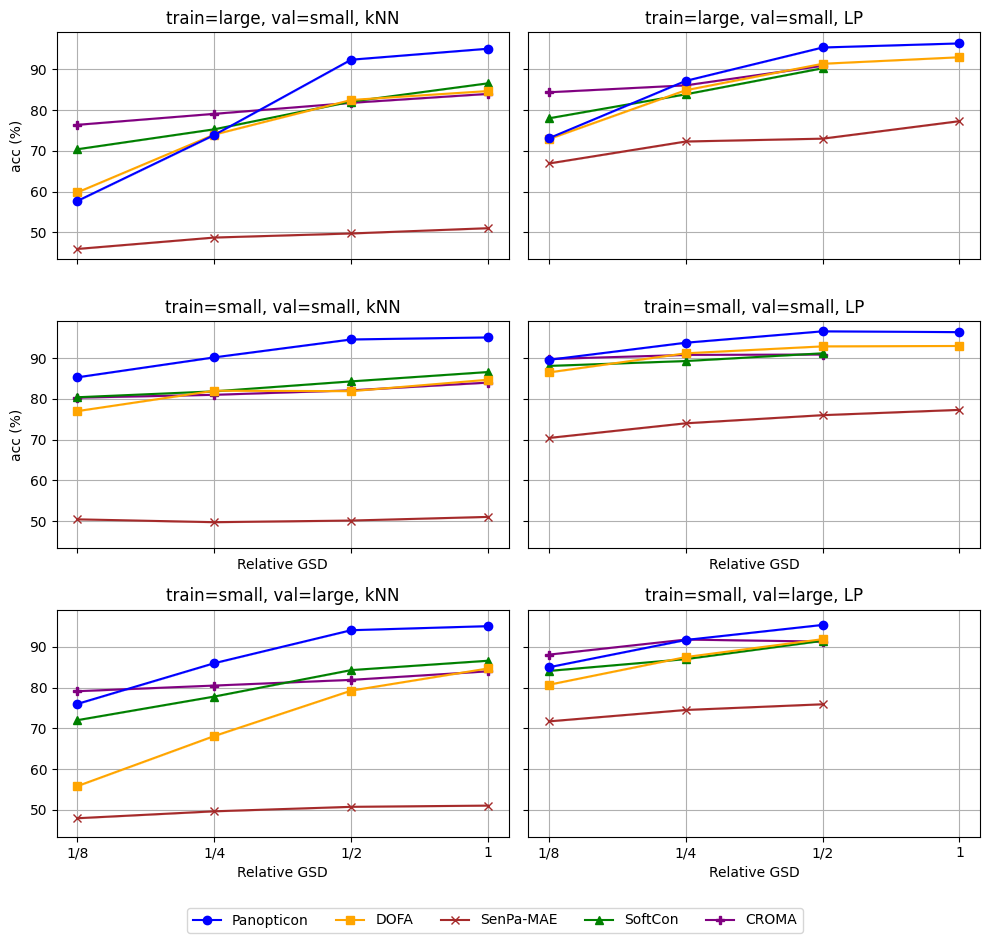

In [78]:
#### plot eurosat

names = {
    'only_val': 'train=large, val=small',
    'only_train': 'train=small, val=large',
    'also_train': 'train=small, val=small',
}

fig, axs = plt.subplots(3,2, figsize=(10, 9), sharex=True, sharey=True)
axs = axs.flatten()

kwargs = dict(collect=False, exclude=['dinov2'], even_xticks=True)

ax = axs[0]
plot_gsd_inv('only_val/m-eurosat/knn', ax=ax, **kwargs)
ax.set_ylabel('acc (%)')
ax.set_xlabel('')
# ax.set_xticks([12.5, 25, 50,100])
# ax.set_xlabel('Relative GSD')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
ax.set_title('train=large, val=small, kNN')

ax = axs[1]
plot_gsd_inv('only_val/m-eurosat/linear_probe', ax=ax, **kwargs)
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_xticks([12.5, 25, 50,100])
# ax.set_xlabel('Relative GSD')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
ax.set_title('train=large, val=small, LP')

ax = axs[2]
plot_gsd_inv('also_train/m-eurosat/knn', ax=ax, **kwargs)
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD')
# ax.set_xticks([12.5, 25, 50, 100])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
ax.set_title('train=small, val=small, kNN')

ax = axs[3]
plot_gsd_inv('also_train/m-eurosat/linear_probe', ax=ax, **kwargs)
ax.set_ylabel('')
# ax.set_xticks([12.5, 25, 50,100])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
ax.set_xlabel('Relative GSD')
ax.set_title('train=small, val=small, LP')

ax = axs[4]
plot_gsd_inv('only_train/m-eurosat/knn', ax=ax, **kwargs)
ax.set_ylabel('')
# ax.set_xticks([12.5, 25, 50,100])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
ax.set_xlabel('Relative GSD')
ax.set_title('train=small, val=large, kNN')

ax = axs[5]
plot_gsd_inv('only_train/m-eurosat/linear_probe', ax=ax, **kwargs)
ax.set_ylabel('')
# ax.set_xticks([12.5, 25, 50,100])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
ax.set_xlabel('Relative GSD')
ax.set_title('train=small, val=large, LP')

fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6)

plt.tight_layout()
plt.show()



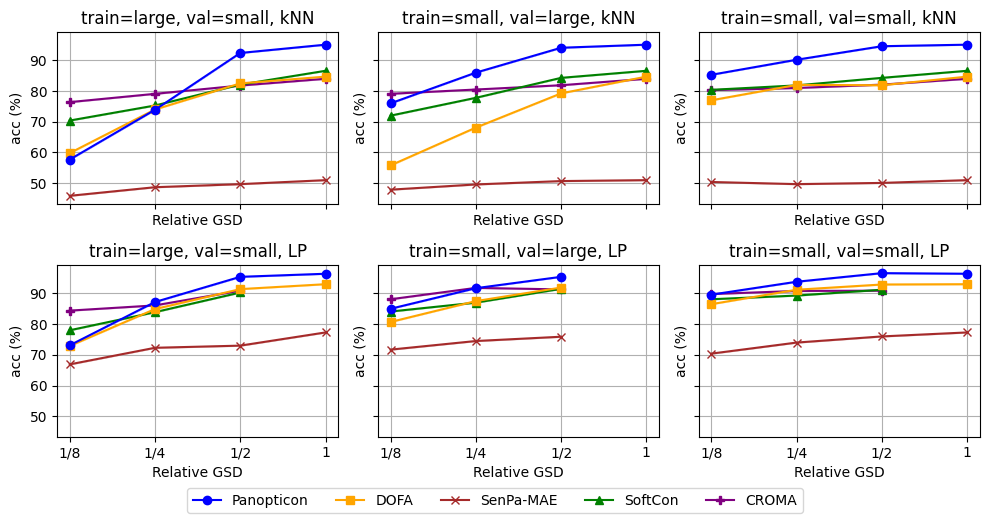

In [81]:
#### plot eurosat

names = {
    'only_val': 'train=large, val=small',
    'only_train': 'train=small, val=large',
    'also_train': 'train=small, val=small',
}

fig, axs = plt.subplots(2,3, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()

kwargs = dict(collect=False, exclude=['dinov2'], even_xticks=True)

def set_ax(ax):
    ax.set_ylabel('acc (%)')
    ax.set_xlabel('Relative GSD')
    # ax.set_xticks([12.5, 25, 50, 100])
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['1/8', '1/4', '1/2', '1'])
    ax.grid(True)

ax = axs[0]
plot_gsd_inv('only_val/m-eurosat/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=large, val=small, kNN')

ax = axs[1]
plot_gsd_inv('only_train/m-eurosat/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=large, kNN')

ax = axs[2]
plot_gsd_inv('also_train/m-eurosat/knn', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=small, kNN')

ax = axs[3]
plot_gsd_inv('only_val/m-eurosat/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=large, val=small, LP')

ax = axs[4]
plot_gsd_inv('only_train/m-eurosat/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=large, LP')

ax = axs[5]
plot_gsd_inv('also_train/m-eurosat/linear_probe', ax=ax, **kwargs)
set_ax(ax)
ax.set_title('train=small, val=small, LP')



fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6)

plt.tight_layout()
plt.show()



also_train/resisc45/knn
also_train/resisc45/linear_probe
only_val/resisc45/knn
only_val/resisc45/linear_probe


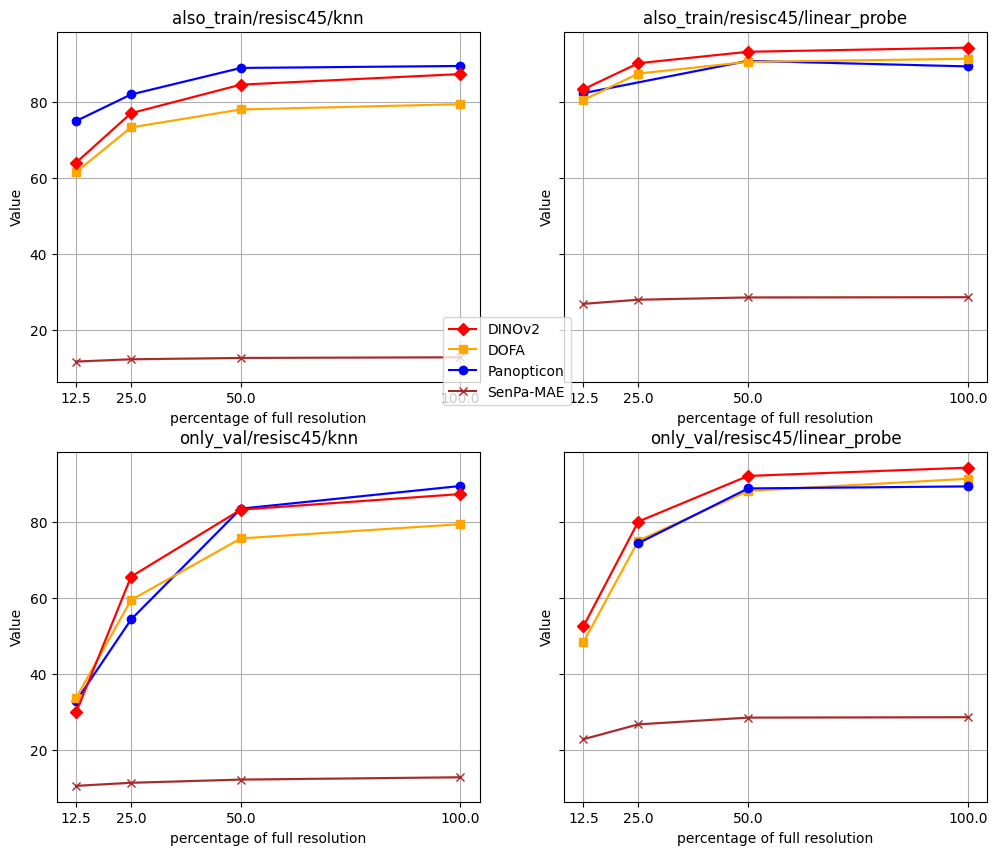

In [ ]:
#### plot resissc

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_inv'
folders = [
    'also_train/resisc45/knn',
    'also_train/resisc45/linear_probe',
    'only_val/resisc45/knn',
    'only_val/resisc45/linear_probe',
]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()

for i, folder in enumerate(folders):
    print(folder)
    ax = axs[i]
    plot_gsd_inv(os.path.join(root, folder), collect=True, ax=ax)
    ax.set_title(folder)
    ax.set_xticks([12.5, 25, 50,100])


fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, 0.5), 
    ncol=1)
plt.show()

also_train/m-brick-kiln/knn
also_train/m-brick-kiln/linear_probe
only_val/m-brick-kiln/knn
only_val/m-brick-kiln/linear_probe


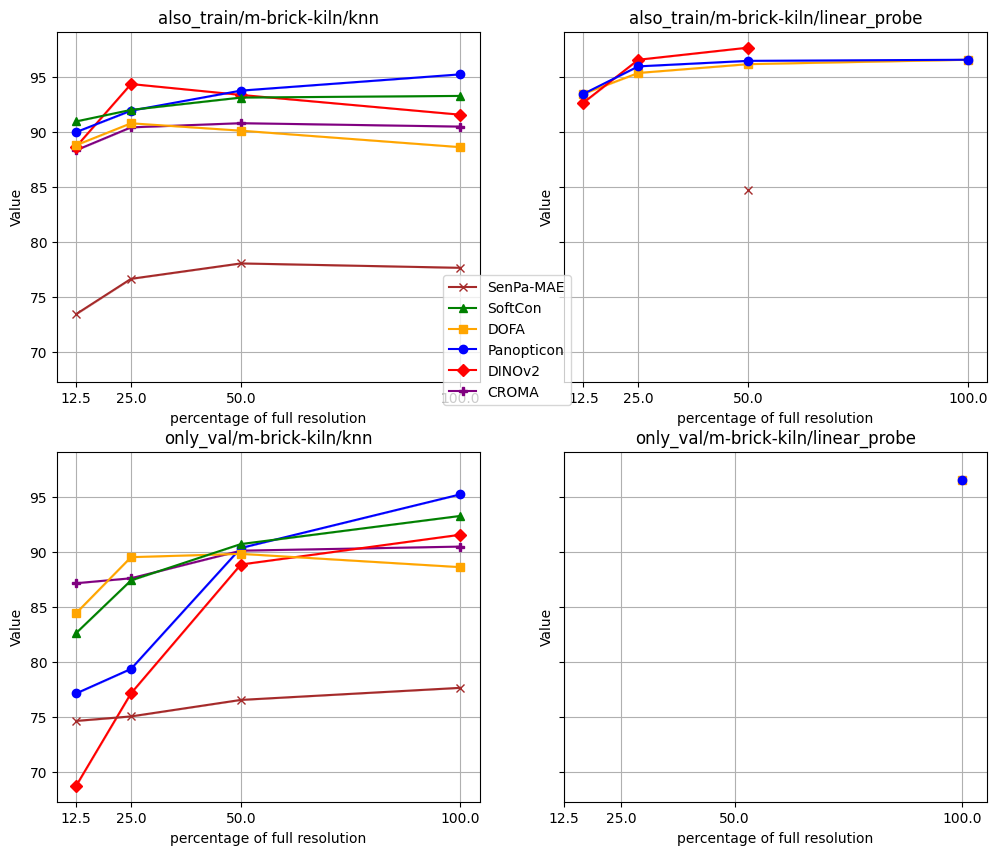

In [6]:
#### plot m-brick-kiln

folders = [
    'also_train/m-brick-kiln/knn',
    'also_train/m-brick-kiln/linear_probe',
    'only_val/m-brick-kiln/knn',
    'only_val/m-brick-kiln/linear_probe',
]

fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()

for i, folder in enumerate(folders):
    print(folder)
    ax = axs[i]
    plot_gsd_inv(folder, collect=True, ax=ax)
    ax.set_title(folder)
    ax.set_xticks([12.5, 25, 50,100])


fig.legend(
    handles=reversed(axs[0].get_legend_handles_labels()[0]), 
    labels=reversed(axs[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, 0.5), 
    ncol=1)
plt.show()

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,1
panopticon,5,5,5,5,1
senpamae,5,5,5,5,1


nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,3
panopticon,5,5,5,5,5
senpamae,5,5,5,5,5


nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,5
panopticon,5,5,5,5,5
senpamae,4,5,5,5,5


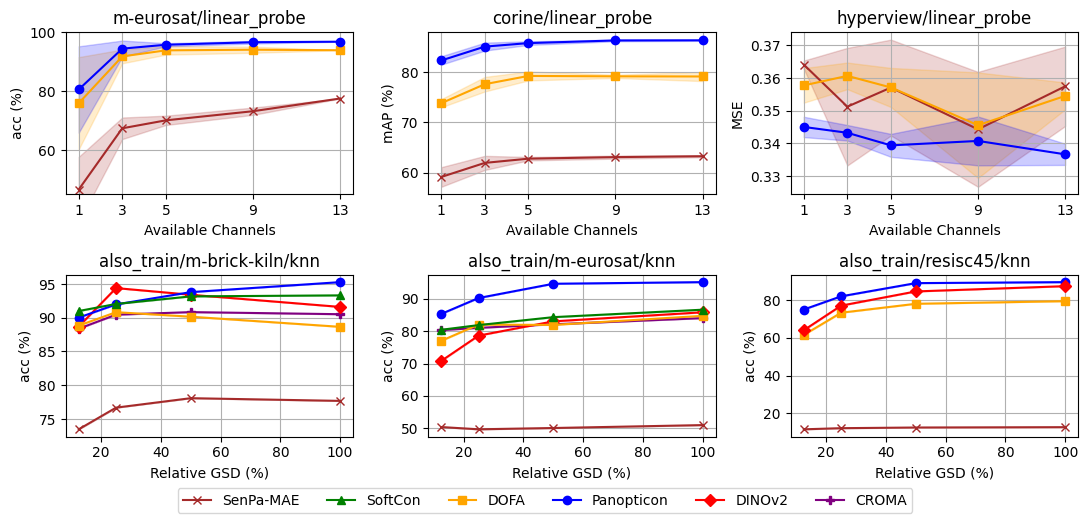

In [81]:
""" joint figure """

import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(2, 3, figsize=(11, 5))
axes = axes.flatten()

kwargs = dict(collect=False, dinov2=False, verbose=True, chn_ids=[1,3,5,9,13])

# plot_spec_inv('m-eurosat/knn', ax=axes[0], drop=('senpamae',1), **kwargs)
# # plot_spec_inv('m-eurosat/knn', ax=axes[0], **kwargs)
# axes[0].set_ylim(45,100)
# axes[0].set_ylabel('acc (%)')
# axes[0].set_xlabel('Number of Channels')

ax = axes[0]
plot_spec_inv('m-eurosat/linear_probe', ax=ax, **kwargs)
ax.set_ylim(45,100)
ax.set_ylabel('acc (%)')
ax.set_xlabel('Available Channels')

ax = axes[1]
plot_spec_inv('corine/linear_probe', metric='MulLabAvergPrec_micro', ax=ax, **kwargs)
ax.set_ylabel('mAP (%)')
ax.set_xlabel('Available Channels')

ax = axes[2]
plot_spec_inv('hyperview/linear_probe', ax=ax, metric='MSE', **kwargs)
ax.set_ylabel('MSE')
ax.set_xlabel('Available Channels')

ax=axes[3]
plot_gsd_inv('also_train/m-brick-kiln/knn', ax=ax, collect=False, )
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD (%)')

ax=axes[4]
plot_gsd_inv('also_train/m-eurosat/knn', ax=ax, collect=False, )
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD (%)')

ax=axes[5]
plot_gsd_inv('also_train/resisc45/knn', ax=ax, collect=False, )
ax.set_ylabel('acc (%)')
ax.set_xlabel('Relative GSD (%)')

# fig.suptitle('test')
fig.legend(
    handles=reversed(axes[3].get_legend_handles_labels()[0]), 
    labels=reversed(axes[3].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6)

plt.tight_layout()
plt.show()

figroot = '/home/hk-project-pai00028/tum_mhj8661/code/z_figs'
fig.savefig(os.path.join(figroot,"gsd_spec_inv.pdf"), format="pdf", bbox_inches='tight')


,prc,model,mean,std,count
0,12.5,dofa,86.100000,0.0,1
1,16.6,dofa,89.800000,0.0,1
2,16.6,panopticon,92.600000,0.0,1
3,25.0,dofa,91.299999,0.0,1
4,25.0,panopticon,93.699998,0.0,1
5,50.0,dofa,92.299998,0.0,1
6,50.0,panopticon,96.700001,0.0,1
7,100.0,dofa,93.900001,0.0,1
8,100.0,panopticon,96.799999,0.0,1


,prc,model,mean,std,count
0,12.5,dofa,72.899997,0.0,1
1,12.5,panopticon,73.699999,0.0,1
2,25.0,dofa,85.000002,0.0,1
3,25.0,panopticon,86.100000,0.0,1
4,50.0,dofa,91.600001,0.0,1
5,50.0,panopticon,95.400000,0.0,1
6,100.0,dofa,93.900001,0.0,1
7,100.0,panopticon,96.799999,0.0,1


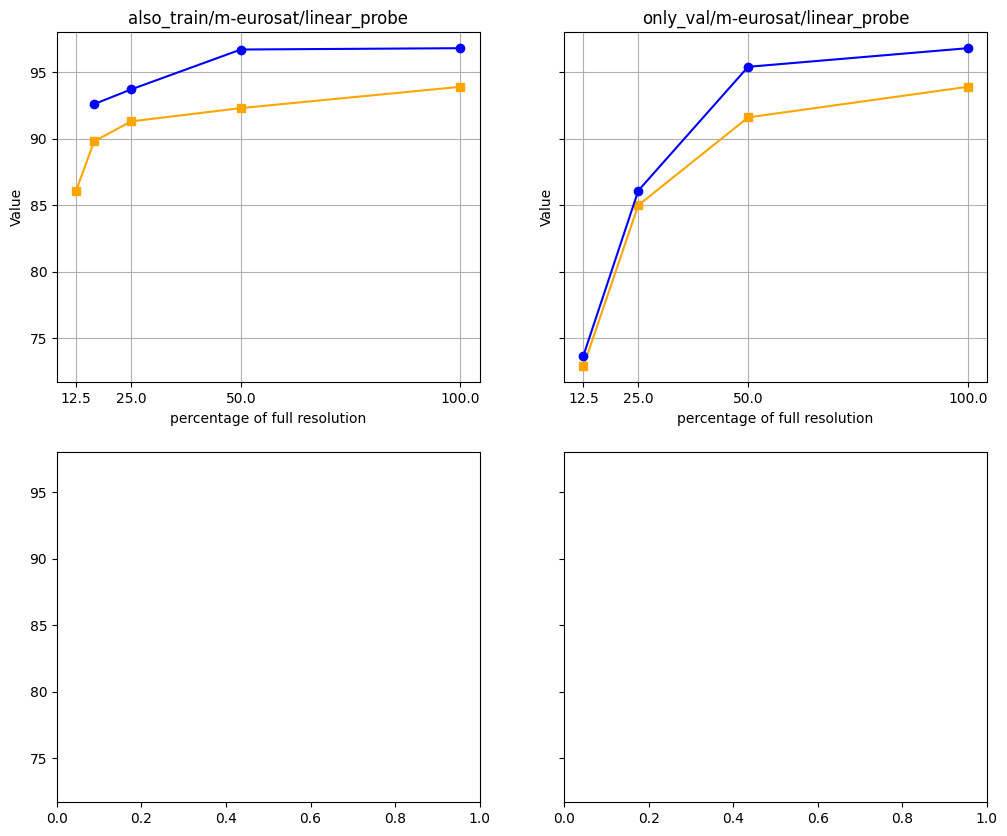

In [ ]:
""" new gsd invariance """

import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os


def plot_gsd(ds_name, metric='acc_top-1_micro', collect=True, ax=None, dinov2=True, nchns=13, mode='linear_probe', verbose=True):
    
    # get the df
    
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_spec_inv/'
    
    p = os.path.join(root, ds_name)
    if collect:
        collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


    df = df[df['metric'] == metric]
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
    df = df[df['mode'] == mode]
    df['prc'] = pd.to_numeric(df['relpath'].apply(lambda x: x.split('/')[2]))
    df['nchns'] = pd.to_numeric(df['relpath'].apply(lambda x: x.split('/')[3]))
    df = df[df['nchns'] == nchns]
    df['chn_ids'] = df['relpath'].apply(lambda x: x.split('/')[4])
    if not dinov2:
        df = df[~df['model'].isin(['dinov2', 'dinov2-PE'])]

    df = df.groupby(['model','prc','nchns','chn_ids'])['val'].agg('max').reset_index()
    df.rename(columns={'max':'val'}, inplace=True)

    if df['val'].max() <= 1.0:
        df['val'] = df['val']*100

    # actually start processing


    dfplot = df.groupby(['prc', 'model'])['val'].agg(['mean','std','count']).reset_index()
    dfplot.sort_values('prc', inplace=True)
    dfplot.fillna(0.0, inplace=True)
    if verbose:
        display(dfplot)

    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(6, 4))

    for model in dfplot['model'].unique():
        model_data = dfplot[dfplot['model'] == model]
        color, marker, model_name = get_aestetics(model)
        ax.plot(model_data['prc'], model_data['mean'], label=model_name, color=color, marker=marker)
        # ax.fill_between(model_data['mean'], 
        #         model_data['mean'] - model_data['std'], 
        #         model_data['mean'] + model_data['std'], 
        #         alpha=0.2,
        #         color=color )
        
    ax.set_xlabel('percentage of full resolution')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.set_title(f'{ds_name}{mode}')

    if standalone:
        plt.legend()
        plt.show()


fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

ax = axs[0][0]
plot_gsd('also_train/m-eurosat/', collect=False, mode='linear_probe', nchns=13, ax=ax)
ax.set_xticks([12.5, 25, 50,100])

ax = axs[0][1]
plot_gsd('only_val/m-eurosat/', collect=True, mode='linear_probe', nchns=13, ax=ax)
ax.set_xticks([12.5, 25, 50,100])

plt.show()
plt.legend()

### Spectral invariance

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from geobreeze.collect_results import collect_csv
import os


def plot_spec_inv(ds_name, metric='acc_top-1_micro', collect=True, verbose=True, ax=None, dinov2=True, chn_ids=None, drop=None):
    root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/'
    
    p = os.path.join(root, ds_name)
    if collect:
        collect_csv(p)
    df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


    df = df[df['metric'] == metric]
    df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
    df['nchns'] = df['relpath'].apply(lambda x: x.split('/')[1])
    if not dinov2:
        df = df[~df['model'].isin(['dinov2', 'dinov2-PE'])]

    dfplot = df.groupby(['nchns', 'model'])['val'].agg(['mean', 'std','count']).reset_index()
    dfplot['nchns'] = pd.to_numeric(dfplot['nchns'])
    if chn_ids is not None:
        dfplot = dfplot[dfplot['nchns'].isin(chn_ids)]
    if drop is not None:
        if isinstance(drop, tuple):
            drop = [drop]
        for t in drop:
            model, nchns = t
            dfplot = dfplot[~((dfplot['model'] == model) & (dfplot['nchns'] == nchns))]
    if verbose:
        display(dfplot.pivot(index='model', columns='nchns', values='count').fillna(0.0).astype(int))
    dfplot.sort_values('nchns', inplace=True)
    dfplot.fillna(0.0, inplace=True)
    if dfplot['mean'].max() <= 1.0 and metric != 'MSE':
        dfplot['mean'] = dfplot['mean']*100
        dfplot['std'] = dfplot['std']*100


    # Plot mean with ± std as bands
    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(6, 4))

    for model in reversed(list(MODEL_TO_AESTETICS.keys())):
        if model not in dfplot['model'].unique(): 
            continue
        model_data = dfplot[dfplot['model'] == model]
        color, marker, model_name = get_aestetics(model)

        ax.plot(model_data['nchns'], model_data['mean'], label=model_name, color=color, marker=marker)
        ax.fill_between(model_data['nchns'], 
                        model_data['mean'] - model_data['std'], 
                        model_data['mean'] + model_data['std'], 
                        alpha=0.2, 
                        color=color)
        
    ax.set_title(ds_name)
    ax.set_xlabel('Number of Channels (nchns)')
    if chn_ids is not None:
        # ax.set_xticks(ticks=range(1, 14, 2))
        ax.set_xticks(ticks=chn_ids)
    ax.set_ylabel('Value (val)')
    ax.grid(True)
    if standalone:
        plt.legend()
        plt.show()
    return ax

# eurosat_knn = plot_spec_inv('m-eurosat/knn', collect=False)
# plot_spec_inv('m-eurosat/knn', drop=('senpamae',1))

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,1
panopticon,5,5,5,5,1
senpamae,5,5,5,3,0


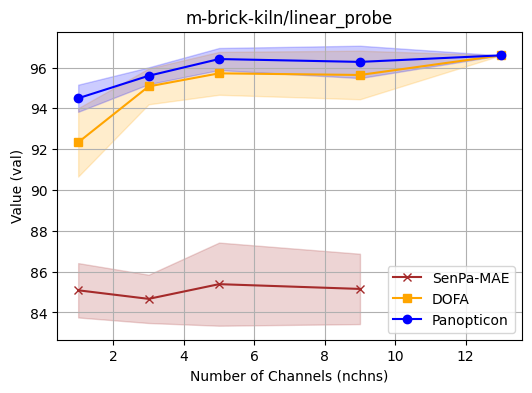

<Axes: title={'center': 'm-brick-kiln/linear_probe'}, xlabel='Number of Channels (nchns)', ylabel='Value (val)'>

In [4]:
plot_spec_inv('m-brick-kiln/linear_probe')

nchns,1,3,5,7,9,11,13
model,,,,,,,
dinov2,0,5,0,0,0,0,0
dofa,5,5,5,5,5,5,1
panopticon,5,5,5,5,5,5,1
senpamae,5,5,5,5,5,5,1


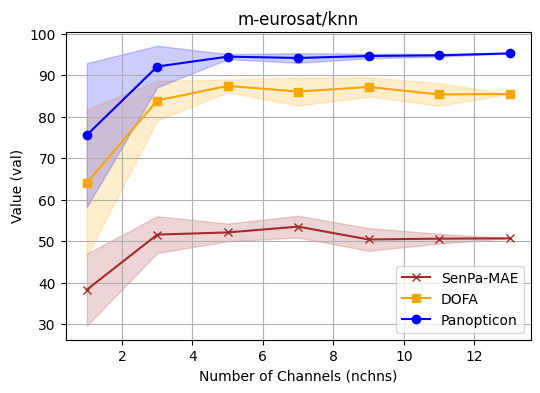

nchns,1,3,5,6
model,,,,
dinov2,0,5,0,0
dofa,5,5,5,1
panopticon,5,5,5,1
senpamae,5,5,5,1


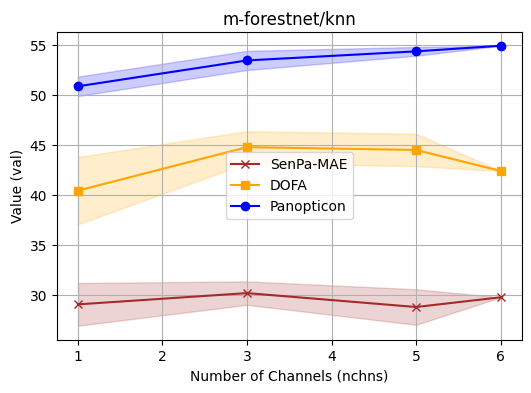

nchns,1,3,5,7,9,11,13
model,,,,,,,
dofa,5,5,5,5,5,5,1
panopticon,5,5,5,5,5,5,1
senpamae,5,5,5,5,5,5,1


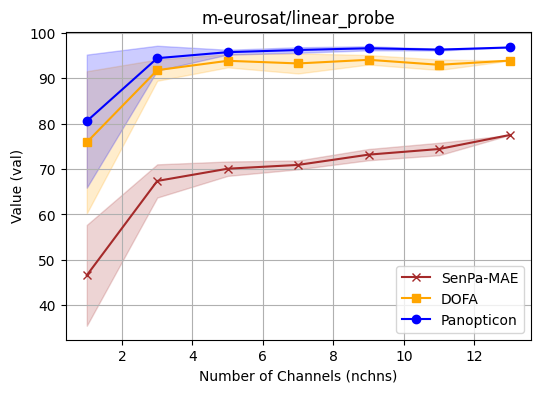

nchns,1,3,5,6
model,,,,
dofa,5,5,5,1
panopticon,5,5,5,1
senpamae,5,5,5,1


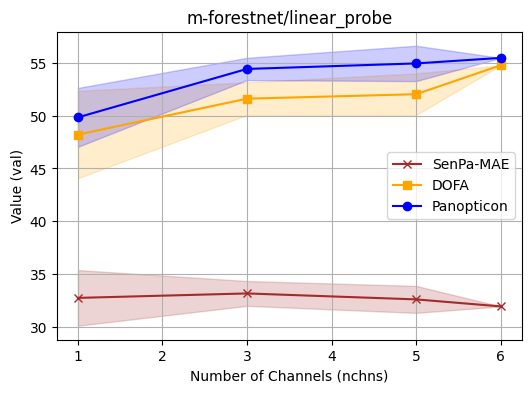

In [135]:
collect = False
eurosat_knn = plot_spec_inv('m-eurosat/knn', collect=collect)
plot_spec_inv('m-forestnet/knn', collect=collect)
eurosat_lin = plot_spec_inv('m-eurosat/linear_probe', collect=collect)
forestnet_lin = plot_spec_inv('m-forestnet/linear_probe', collect=collect)

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,5
panopticon,5,5,5,5,5
senpamae,4,5,5,5,5


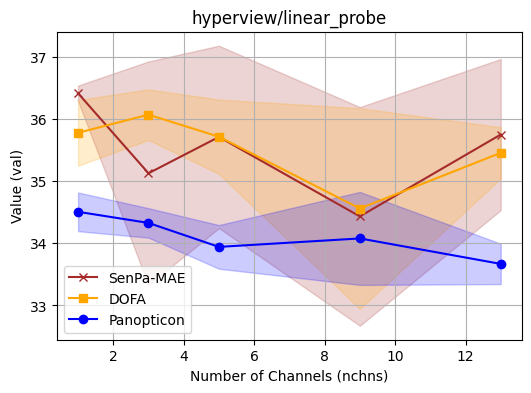

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,3
panopticon,5,5,5,5,5
senpamae,5,2,3,4,5


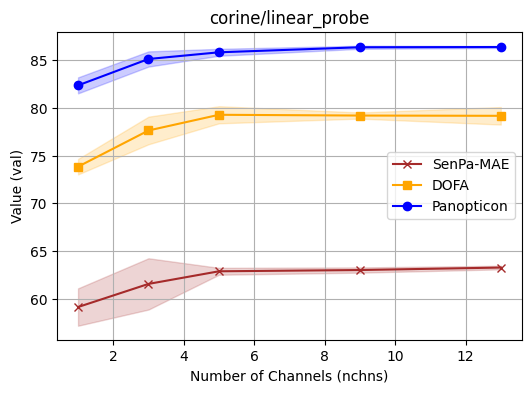

<Axes: title={'center': 'corine/linear_probe'}, xlabel='Number of Channels (nchns)', ylabel='Value (val)'>

In [186]:
plot_spec_inv('hyperview/linear_probe', metric='MSE')
plot_spec_inv('corine/linear_probe', metric='MulLabAvergPrec_micro')

nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,1
panopticon,5,5,5,5,1
senpamae,5,5,5,5,1


nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,3
panopticon,5,5,5,5,5
senpamae,5,5,5,5,5


nchns,1,3,5,9,13
model,,,,,
dofa,5,5,5,5,5
panopticon,5,5,5,5,5
senpamae,4,5,5,5,5


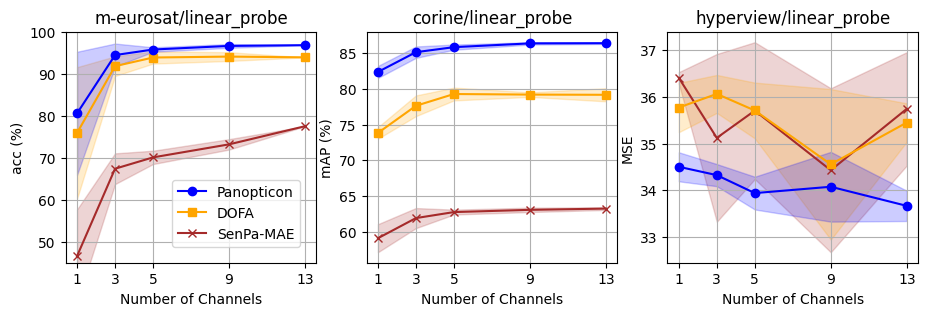

In [5]:
import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(1, 3, figsize=(11, 3))

kwargs = dict(collect=True, dinov2=False, verbose=True, chn_ids=[1,3,5,9,13])

# plot_spec_inv('m-eurosat/knn', ax=axes[0], drop=('senpamae',1), **kwargs)
# # plot_spec_inv('m-eurosat/knn', ax=axes[0], **kwargs)
# axes[0].set_ylim(45,100)
# axes[0].set_ylabel('acc (%)')
# axes[0].set_xlabel('Number of Channels')

ax = axes[0]
plot_spec_inv('m-eurosat/linear_probe', ax=ax, **kwargs)
ax.set_ylim(45,100)
ax.set_ylabel('acc (%)')
ax.set_xlabel('Number of Channels')

ax = axes[1]
plot_spec_inv('corine/linear_probe', metric='MulLabAvergPrec_micro', ax=ax, **kwargs)
ax.set_ylabel('mAP (%)')
ax.set_xlabel('Number of Channels')

ax = axes[2]
plot_spec_inv('hyperview/linear_probe', ax=ax, metric='MSE', **kwargs)
ax.set_ylabel('MSE')
ax.set_xlabel('Number of Channels')




# fig.suptitle('test')
fig.legend(
    handles=reversed(axes[0].get_legend_handles_labels()[0]), 
    labels=reversed(axes[0].get_legend_handles_labels()[1]), 
    loc='lower center',
    bbox_to_anchor=(0.28, 0.14), 
    ncol=1)
plt.show()

figroot = '/home/hk-project-pai00028/tum_mhj8661/code/z_figs'
fig.savefig(os.path.join(figroot,"spec_inv.pdf"), format="pdf", bbox_inches='tight')

In [2]:
""" generate random channel combinations"""

import numpy as np
import math

all_chns = 13
n_chns = [1,3,5,9,13]
subsets_per_n_chns = 5

for chn in n_chns:
    already_used = set()
    n_subsets = min(
        subsets_per_n_chns, 
        math.factorial(all_chns) // (math.factorial(all_chns - chn) * math.factorial(chn)))
    for _ in range(n_subsets):
        def sample():
            l = np.random.choice(range(all_chns), chn, replace=False).tolist()
            l = sorted(l)
            return tuple(l)

        chns = sample()
        while chns in already_used:
            chns = sample()
        already_used.add(chns)

        print(f'  \"{chn:2d} {str(list(chns)).replace(" ","")}\"')

  " 1 [12]"
  " 1 [11]"
  " 1 [2]"
  " 1 [4]"
  " 1 [10]"
  " 3 [1,9,11]"
  " 3 [5,8,9]"
  " 3 [1,8,11]"
  " 3 [1,4,8]"
  " 3 [3,6,12]"
  " 5 [1,2,6,8,9]"
  " 5 [1,4,6,9,12]"
  " 5 [0,1,3,4,10]"
  " 5 [2,3,6,11,12]"
  " 5 [2,3,5,7,9]"
  " 9 [2,3,4,5,6,7,9,10,12]"
  " 9 [1,3,4,5,6,7,8,10,12]"
  " 9 [0,2,4,6,7,8,10,11,12]"
  " 9 [0,1,2,3,5,6,9,10,11]"
  " 9 [0,1,4,5,7,8,9,10,12]"
  "13 [0,1,2,3,4,5,6,7,8,9,10,11,12]"


### Dataset Debugging

In [1]:
from omegaconf import OmegaConf, open_dict
from geobreeze.factory import make_model

p = '/home/hk-project-pai00028/tum_mhj8661/code/geobreeze/geobreeze/config/model/base/panopticon.yaml'
cfg = OmegaConf.load(p)
with open_dict(cfg):
    cfg.blk_indices = cfg.blk_indices.linear_probe
model = make_model(cfg)

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/panopticon-FM_panopticon_main
/home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/panopticon-FM_panopticon_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/hk-project-pai00028/tum_mhj8661/.cache/torch/hub/pano

Loaded encoder with blocks [8, 9, 10, 11] blocks and norm LayerNorm((768,), eps=1e-06, elementwise_affine=True)


In [2]:
from geobreeze.factory import make_dataset
from omegaconf import OmegaConf

p = '/home/hk-project-pai00028/tum_mhj8661/code/segm_test.yaml'
cfg = OmegaConf.load(p)

ds = make_dataset(cfg.data.train, normalize=False)
x_dict, mask = ds[0]

/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hk-project-pai00028/tum_mhj8661/miniforge3/envs/eval/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


{'_target_': 'K.RandomHorizontalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'K.RandomVerticalFlip', 'p': 0.5, 'keepdim': True}
{'_target_': 'K.Resize', 'size': 224, 'keepdim': True}


In [4]:
ds[0][0].keys()

dict_keys(['imgs', 'chn_ids'])

In [5]:
ds.calibrate(band_ids=[1,4,5])

INFO:eval:Subsampled 3/12 bands with ids [1, 4, 5]. Band names are:
  000: 02 - Blue
  001: 05 - Vegetation Red Edge
  002: 06 - Vegetation Red Edge


In [6]:
ds[0][0]['imgs'].shape

torch.Size([3, 224, 224])

In [7]:
ds[0][0]['chn_ids']

tensor([492.9971, 704.0059, 740.5521])

In [2]:
import os

root = '/home/hk-project-pai00028/tum_mhj8661/code/fm-playground/geofm_src/foundation_models/SenPaMAE/responsefunctions'
os.listdir(root)

['rfs_sentinel2_a.npy',
 'rfs_modis_terra.npy',
 'rfs_enmap_recon.npy',
 'rfs_wv23_recon.npy',
 'rfs_sentinel2_b.npy',
 'rfs_sentinel2_a_13b.npy',
 'rfs_landsat.npy',
 'rfs_superdove.npy']

In [5]:
import numpy as np

srfs = {}
for f in os.listdir(root):
    if f.endswith('.npy'):
        data = np.load(os.path.join(root,f))
        srfs[f.removesuffix('.npy')] = data

for f, d in srfs.items():
    print(f, d.shape)

rfs_sentinel2_a (2301, 10)
rfs_modis_terra (2301, 16)
rfs_enmap_recon (2301, 224)
rfs_wv23_recon (2301, 8)
rfs_sentinel2_b (2301, 10)
rfs_sentinel2_a_13b (2301, 13)
rfs_landsat (2301, 7)
rfs_superdove (2301, 8)


In [13]:
f1 = 'rfs_sentinel2_a'
f2 = 'rfs_sentinel2_a_13b'

out = np.ones([srfs[f1].shape[1], srfs[f2].shape[1]]) * -1
for i in range(srfs[f1].shape[1]):
    for j in range(srfs[f2].shape[1]):
        out[i,j] = np.allclose(srfs[f1][:,i], srfs[f2][:,j]) 

print(out)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [7]:
ds.calibrate(band_ids= None)

INFO:eval:Subsampled 12/12 bands with ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]. Band names are:
  000: 01 - Coastal aerosol
  001: 02 - Blue
  002: 03 - Green
  003: 04 - Red
  004: 05 - Vegetation Red Edge
  005: 06 - Vegetation Red Edge
  006: 07 - Vegetation Red Edge
  007: 08 - NIR
  008: 08A - Vegetation Red Edge
  009: 09 - Water vapour
  010: 11 - SWIR
  011: 12 - SWIR


In [9]:
metainfo = {
    'chn_ids': 'bands.gaussian.mu',
    'gsd': 'bands.GSD',
    'senpamae_srf_name': 'senpamae_srf_name'
}
ds.calibrate(metainfo=metainfo)

ds[0]

INFO:eval:Subsampled 12/12 bands with ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]. Band names are:
  000: 01 - Coastal aerosol
  001: 02 - Blue
  002: 03 - Green
  003: 04 - Red
  004: 05 - Vegetation Red Edge
  005: 06 - Vegetation Red Edge
  006: 07 - Vegetation Red Edge
  007: 08 - NIR
  008: 08A - Vegetation Red Edge
  009: 09 - Water vapour
  010: 11 - SWIR
  011: 12 - SWIR


({'imgs': tensor([[[ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           [ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           [ 326.0000,  326.0000,  318.8251,  ...,  330.0000,  330.0000,
             330.0000],
           ...,
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001],
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001],
           [ 316.0000,  316.0000,  319.4439,  ...,  282.0000,  282.0000,
             278.0001]],
  
          [[ 394.0000,  390.2780,  374.5471,  ...,  564.1841,  501.8976,
             480.0002],
           [ 403.7175,  376.9169,  374.3644,  ...,  522.4305,  516.6534,
             439.7141],
           [ 410.8700,  396.7253,  372.7646,  ...,  501.2694,  462.4356,
             443.7401],
           ...,
           [ 354.8159,  344.2336,  358.6949,  ...,  350.4633,  322.1515,
          

torch.Size([12, 224, 224])
torch.Size([224, 224])


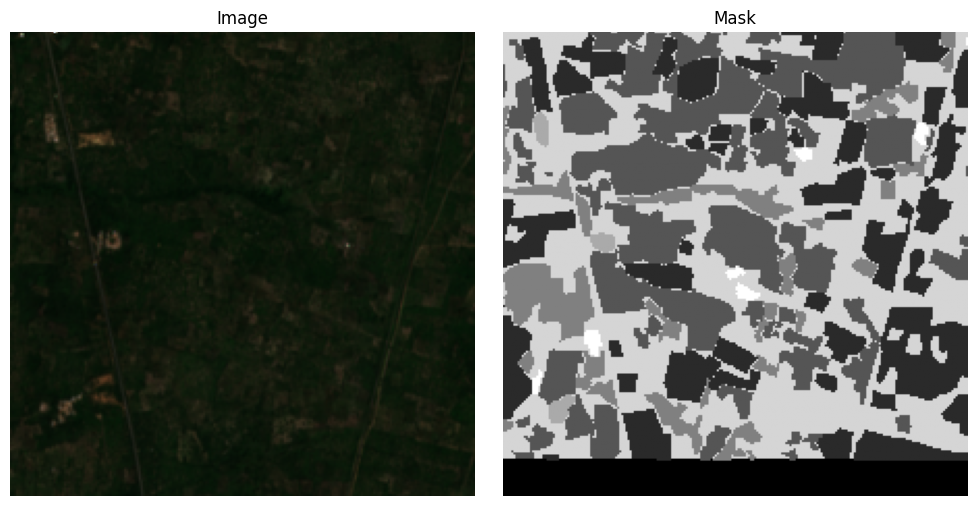

torch.Size([12, 224, 224])
torch.Size([224, 224])


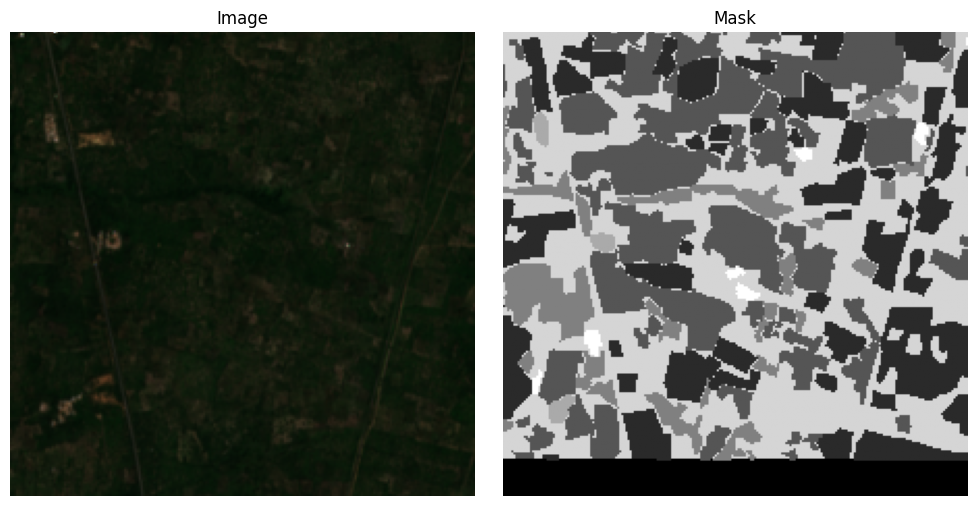

In [16]:
x_dict, mask = ds[100]


img = x_dict['imgs']
mask = mask
print(img.shape)
print(mask.shape)
img = img[[3,2,1]]

img = (img - img.min()) / (img.max() - img.min())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(img.permute(1, 2, 0).numpy())
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the mask
axes[1].imshow(mask.numpy(), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()



img = x_dict['imgs']
mask = mask
print(img.shape)
print(mask.shape)
img = img[[3,2,1]]

img = (img - img.min()) / (img.max() - img.min())

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(img.permute(1, 2, 0).numpy())
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the mask
axes[1].imshow(mask.numpy(), cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [11]:
import kornia as K
import torch

trf = K.augmentation.AugmentationSequential(
    K.augmentation.RandomVerticalFlip(p=1),
    data_keys=['input', 'label'],
)

x = torch.tensor([[1,1],[2,2,]], dtype=torch.float32)
y = torch.tensor([1], dtype=torch.int64)

print(x)

trf(x, y)   

tensor([[1., 1.],
        [2., 2.]])


[tensor([[[[2., 2.],
           [1., 1.]]]]),
 tensor([1])]

### gsd & spec invariance

In [ ]:
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg

collect = False

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/spec_inv/'
ds_name = 'm-eurosat_1band/linear_probe'
metric = 'acc_top-1_micro'
dinov2 = True
chn_ids = None
drop = None
verbose = True

p = os.path.join(root, ds_name)
if collect:
    collect_csv(p)
df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == metric]
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['val'] = round(df['val']*100, 1)
df['chn_id'] = df['relpath'].apply(lambda x: int(x.split('/')[2].removeprefix('[').removesuffix(']')))
df = df.groupby(['model','chn_id'])['val'].agg(['max']).reset_index()
# display(df)


display(df.pivot(index='model', columns='chn_id', values='max'))
display(round(df.pivot(index='model', columns='chn_id', values='max') / df.pivot(index='model', columns='chn_id', values='max').mean(axis=1).values[:,None], 2))

bands = load_ds_cfg('m-eurosat')['bands']
gsds = [b['GSD'] for b in bands]

df['gsds'] = df['chn_id'].apply(lambda x: gsds[x])
round(df.groupby(['model','gsds'])['max'].agg(['mean','std','count']).reset_index(), 2)

chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,61.2,91.1,92.6,91.8,81.5,82.4,82.6,90.3,57.8,39.3,85.5,81.3,79.9
panopticon,67.3,92.1,94.0,92.5,89.5,86.5,87.3,93.0,63.2,40.6,86.4,88.6,89.1
senpamae,32.1,49.7,56.8,55.9,56.2,54.1,53.8,61.5,40.6,30.8,55.4,59.8,55.3


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,0.78,1.16,1.18,1.17,1.04,1.05,1.06,1.15,0.74,0.50,1.09,1.04,1.02
panopticon,0.82,1.12,1.14,1.12,1.09,1.05,1.06,1.13,0.77,0.49,1.05,1.08,1.08
senpamae,0.63,0.98,1.12,1.10,1.10,1.06,1.06,1.21,0.80,0.60,1.09,1.17,1.09


,model,gsds,mean,std,count
0,dofa,10,91.45,0.98,4
1,dofa,20,77.58,9.74,6
2,dofa,60,62.00,23.11,3
3,panopticon,10,92.90,0.82,4
4,panopticon,20,84.03,10.27,6
5,panopticon,60,64.77,23.00,3
6,senpamae,10,55.98,4.85,4
7,senpamae,20,53.30,6.59,6
8,senpamae,60,39.43,13.84,3


In [ ]:
""" these results are knn!"""
import os
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg
from geobreeze.collect_results import collect_csv   

p = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_inv2/also_train/m-eurosat_gsdinv/knn/'
# collect_csv(p)

df = pd.read_csv(os.path.join(p,'results.csv')).drop(columns=['Unnamed: 0'])


df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
# df['val'] = round(df['val']*100, 1)
df['prc'] = df['relpath'].apply(lambda x: float(x.split('/')[1]))
df['chn_id'] = df['relpath'].apply(lambda x: int(x.split('/')[2].removeprefix('[').removesuffix(']')))
# df = df.groupby(['model','chn_id'])['val'].agg(['max']).reset_index()


for prc in sorted(df['prc'].unique(), reverse=True):
    print(prc)
    plotdf = df[df['prc'] == prc]
    display(plotdf.pivot(index='model', columns='chn_id', values='val'))

50.0


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,50.5,80.14,81.0,81.8,69.4,66.6,67.0,77.3,43.0,31.2,67.6,70.0,63.20
panopticon,58.6,85.10,86.9,86.4,83.1,83.4,82.6,88.3,53.1,37.0,79.9,82.9,82.56


25.0


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,49.6,69.5,71.0,70.02,63.9,59.13,58.94,65.0,43.2,27.3,63.9,66.9,59.7
panopticon,57.8,73.3,76.7,74.90,77.4,75.46,74.05,74.6,52.6,36.9,73.9,74.7,73.9


16.6


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,47.9,58.0,60.7,59.8,59.7,53.5,54.15,57.09,41.2,30.0,59.4,59.1,53.9
panopticon,57.2,66.9,68.7,68.7,68.2,65.8,65.30,65.41,51.5,34.8,67.3,69.5,64.5


12.5


chn_id,0,1,2,3,4,5,6,7,8,9,10,11,12
model,,,,,,,,,,,,,
dofa,47.4,52.8,55.3,53.3,55.6,46.86,46.0,52.67,41.3,28.02,54.5,55.13,49.7
panopticon,54.1,58.0,59.9,59.8,63.8,57.20,57.4,56.21,49.4,34.40,61.1,64.50,57.3


In [2]:
import os
import pandas as pd
from geobreeze.datasets.utils.utils import load_ds_cfg
from geobreeze.collect_results import collect_csv   

root = '/hkfs/work/workspace/scratch/tum_mhj8661-panopticon/dino_logs/geobreeze/gsd_spec_inv/also_train/m-eurosat'
# collect_csv(root)

df = pd.read_csv(os.path.join(root,'results.csv')).drop(columns=['Unnamed: 0'])
df = df[df['metric'] == 'acc_top-1_micro']
df['model'] = df['relpath'].apply(lambda x: x.split('/')[0])
df['mode'] = df['relpath'].apply(lambda x: x.split('/')[1])
df = df[df['mode'] == 'linear_probe']

df['prc'] = df['relpath'].apply(lambda x: float(x.split('/')[2]))
df['nchns'] = df['relpath'].apply(lambda x: int(x.split('/')[3]))
df['chn_ids'] = df['relpath'].apply(lambda x: x.split('/')[4])

df = df.groupby(['model','chn_ids','nchns','prc'])['val'].agg(['max']).reset_index()
df.rename(columns={'max':'val'}, inplace=True)
df

KeyError: 'geobreeze.datasets'

In [54]:
# prc by chn id

for model in ['panopticon','dofa']:
    print('---------------')
    print(model)

    dfp1 = df.groupby(['model','nchns','prc'])['val'].agg(['mean','std']).reset_index()
    dfp1 = dfp1[dfp1['model'] == model]
    dfp = dfp1.pivot(columns='nchns', index='prc', values='mean').sort_index(ascending=False)
    display(round(dfp*100,1))

    nchns_corr = dfp1['nchns'].corr(dfp1['mean'])
    prc_corr = dfp1['prc'].astype(float).corr(dfp1['mean'])
    print(f"Correlation of nchns to val: {nchns_corr}")
    print(f"Correlation of prc to val: {prc_corr}")

---------------
panopticon


nchns,1,3,5,7,9,11,13
prc,,,,,,,
100.0,82.3,94.4,95.8,96.2,96.6,96.3,96.8
50.0,80.8,93.7,95.7,95.9,95.9,96.2,96.7
25.0,73.7,90.7,92.8,92.9,94.0,92.9,93.7
16.6,67.5,87.3,90.9,91.2,92.4,92.2,92.6


Correlation of nchns to val: 0.6477646415563819
Correlation of prc to val: 0.3183474909887122
---------------
dofa


nchns,1,3,5,7,9,11,13
prc,,,,,,,
100.0,78.3,91.8,93.9,93.3,94.1,93.0,93.9
50.0,76.6,91.1,92.6,91.8,92.6,92.0,92.3
25.0,70.6,87.6,89.1,89.4,89.6,90.1,91.3
16.6,65.0,83.8,86.7,87.9,88.2,88.6,89.8


Correlation of nchns to val: 0.640977173176033
Correlation of prc to val: 0.3428451125019032
